<a href="https://colab.research.google.com/github/niyantha23/Single-Image-Super-Resolution-SRGAN-/blob/main/AiPROJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Code for Single image super resolution for security**

In [ ]:
!pip install scipy==1.1.0

In [ ]:
!pip install tensorflow==1.15.0


In [ ]:
!pip install keras==2.1.2

In [ ]:
pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
!pip show keras

In [ ]:
!pip show tensorflow

In [ ]:
pip install Pillow imageio

 importing essential modules

In [ ]:
import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense,Flatten
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.misc import imread, imresize
from PIL import Image

In [ ]:
# This method is to load and augment images
def sample_images(data_dir, batch_size, high_resolution_shape, low_resolution_shape):
  
    all_images = glob.glob(data_dir)
  
    images_batch = np.random.choice(all_images, size=batch_size)

    low_resolution_images = []
    high_resolution_images = []

    for img in images_batch:
      
        img1 = imread(img, mode='RGB')
        img1 = img1.astype(np.float32)
       
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)

        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)

        high_resolution_images.append(img1_high_resolution)
        low_resolution_images.append(img1_low_resolution)

    return np.array(high_resolution_images), np.array(low_resolution_images)

In [ ]:

sample_images("/content/img_align_celeba/*.*", 32, high_resolution_shape=(256, 256, 3), low_resolution_shape=(64, 64, 3))

##**Create the model**


1.residual block

In [ ]:
def residual_block(x):
   
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

2.generator model

In [ ]:
def build_generator():
   
    residual_blocks = 16
    momentum = 0.8
    input_shape = (64, 64, 3)

    input_layer = Input(shape=input_shape)

    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)

    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model

3.discriminator model

In [ ]:
def build_discriminator():
  
    leakyrelu_alpha = 0.2
    momentum = 0.8
    input_shape = (256, 256, 3)

    input_layer = Input(shape=input_shape)

    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    flatten = Flatten()(dis8)
    dis9 = Dense(units=1024)(flatten)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

4. VGG19 to extract features 

In [ ]:
def build_vgg():
    
    input_shape = (256, 256, 3)

    vgg = VGG19(weights="imagenet",include_top=False)
    vgg.outputs = [vgg.layers[9].output]

    input_layer = Input(shape=input_shape)

    features = vgg(input_layer)

    model = Model(input_layer, features)
    return model

80142336/80134624 [==============================] - 1s 0us/step


##**Train the model**

1. Mount your google drive to access the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq '/content/drive/My Drive/Datasets/img_align_celeba.zip'

In [ ]:
data_dir = "/content/img_align_celeba/*.*"
epochs = 10000
batch_size = 1

low_resolution_shape = (64, 64, 3)
high_resolution_shape = (256, 256, 3)

common_optimizer = Adam(0.0002, 0.5)

3. Buld the vgg19, discriminator and generator model

In [ ]:
vgg = build_vgg()
vgg.trainable = False
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

discriminator = build_discriminator()
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

generator = build_generator()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
80142336/80134624 [==============================] - 1s 0us/step


4. Build and compile the adversarial model

In [ ]:
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)

generated_high_resolution_images = generator(input_low_resolution)

features = vgg(generated_high_resolution_images)

discriminator.trainable = False

probs = discriminator(generated_high_resolution_images)

adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1],
                          optimizer=common_optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
def save_images(low_resolution_image, original_image, generated_image, path):
    """
    Save images in a single figure
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("Original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)


In [ ]:
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/Datasets/logs/".format(time.time()))
tensorboard.set_model(generator)
tensorboard.set_model(discriminator)

6. Add a for loop

Epoch:0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


1
d_loss: [0.8383672 0.       ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


g_loss: [85.54866, 0.0023872477, 85.54866]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

Epoch:1
1
d_loss: [0.968058 0.      ]
g_loss: [46.41581, 39.6793, 46.37613]
Epoch:2
1
d_loss: [0. 1.]
g_loss: [53.861713, 76.341805, 53.78537]
Epoch:3
1
d_loss: [0. 1.]
g_loss: [52.177357, 103.37596, 52.073982]
Epoch:4
1
d_loss: [1.17296175e-07 1.00000000e+00]
g_loss: [43.663605, 52.155777, 43.61145]
Epoch:5
1
d_loss: [1.3336177e-10 1.0000000e+00]
g_loss: [44.690628, 39.82841, 44.6508]
Epoch:6
1
d_loss: [0. 1.]
g_loss: [50.693775, 65.532, 50.628242]
Epoch:7
1
d_loss: [0. 1.]
g_loss: [39.7636, 94.07704, 39.66952]
Epoch:8
1
d_loss: [0. 1.]
g_loss: [38.40184, 58.466473, 38.343372]
Epoch:9
1
d_loss: [0. 1.]
g_loss: [36.965336, 39.28824, 36.92605]
Epoch:10
1
d_loss: [0. 1.]
g_loss: [57.562027, 82.22948, 57.479797]
Epoch:11
1
d_loss: [0. 1.]
g_loss: [45.47216, 85.442696, 45.38672]
Epoch:12
1
d_loss: [0. 1.]
g_loss: [39.818943, 44.090908, 39.774853]
Epoch:13
1
d_loss: [0. 1.]
g_loss: [35.849453, 48.54848, 35.800903]
Epoch:14
1
d_loss: [0. 1.]
g_loss: [37.080296, 35.982956, 37.04431]
Epoch:15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:201
1
d_loss: [1. 0.]
g_loss: [21.931469, 1.4975257e-34, 21.931469]
Epoch:202
1
d_loss: [0.5 0.5]
g_loss: [10.31574, 0.0, 10.31574]
Epoch:203
1
d_loss: [0.5 0.5]
g_loss: [11.5931015, 0.0, 11.5931015]
Epoch:204
1
d_loss: [0.5 0.5]
g_loss: [15.745115, 0.0, 15.745115]
Epoch:205
1
d_loss: [0.5 0.5]
g_loss: [11.636637, 0.0, 11.636637]
Epoch:206
1
d_loss: [0.5 0.5]
g_loss: [12.134895, 0.0, 12.134895]
Epoch:207
1
d_loss: [0.5 0.5]
g_loss: [16.413015, 0.0, 16.413015]
Epoch:208
1
d_loss: [0. 1.]
g_loss: [9.709551, 0.0, 9.709551]
Epoch:209
1
d_loss: [0.5 0.5]
g_loss: [16.215708, 0.0, 16.215708]
Epoch:210
1
d_loss: [0.5 0.5]
g_loss: [11.976307, 0.0, 11.976307]
Epoch:211
1
d_loss: [0.5 0.5]
g_loss: [11.954833, 0.0, 11.954833]
Epoch:212
1
d_loss: [0.5 0.5]
g_loss: [11.227993, 0.0, 11.227993]
Epoch:213
1
d_loss: [0. 1.]
g_loss: [12.959603, 81.69579, 12.877908]
Epoch:214
1
d_loss: [0.5 0.5]
g_loss: [7.974863, 0.0, 7.974863]
Epoch:215
1
d_loss: [0.5 0.5]
g_loss: [16.321516, 0.0, 16.321516]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:401
1
d_loss: [0.5 0.5]
g_loss: [9.27253, 636.3202, 8.6362095]
Epoch:402
1
d_loss: [0.5 0.5]
g_loss: [9.621413, 665.18085, 8.956232]
Epoch:403
1
d_loss: [0.5 0.5]
g_loss: [6.1203012, 0.0, 6.1203012]
Epoch:404
1
d_loss: [1. 0.]
g_loss: [9.299421, 0.0, 9.299421]
Epoch:405
1
d_loss: [0.5 0.5]
g_loss: [9.584907, 125.243774, 9.459662]
Epoch:406
1
d_loss: [1. 0.]
g_loss: [6.153922, 0.0, 6.153922]
Epoch:407
1
d_loss: [0.5 0.5]
g_loss: [9.467937, 0.0, 9.467937]
Epoch:408
1
d_loss: [0.5 0.5]
g_loss: [12.915224, 0.0, 12.915224]
Epoch:409
1
d_loss: [0.5 0.5]
g_loss: [8.784642, 0.0, 8.784642]
Epoch:410
1
d_loss: [0.5 0.5]
g_loss: [11.377305, 0.0, 11.377305]
Epoch:411
1
d_loss: [0.5 0.5]
g_loss: [6.7158337, 0.0, 6.7158337]
Epoch:412
1
d_loss: [0.5 0.5]
g_loss: [8.665537, 6.117291e-22, 8.665537]
Epoch:413
1
d_loss: [0.5 0.5]
g_loss: [7.3851666, 463.2026, 6.921964]
Epoch:414
1
d_loss: [0.5 0.5]
g_loss: [9.331107, 566.4915, 8.764616]
Epoch:415
1
d_loss: [0.5 0.5]
g_loss: [7.9876204, 0.0, 7.98762

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:601
1
d_loss: [0.5 0.5]
g_loss: [8.638248, 0.0, 8.638248]
Epoch:602
1
d_loss: [0.5 0.5]
g_loss: [5.0315895, 0.0, 5.0315895]
Epoch:603
1
d_loss: [0.5 0.5]
g_loss: [6.3494015, 0.0, 6.3494015]
Epoch:604
1
d_loss: [0.5 0.5]
g_loss: [4.226402, 0.0, 4.226402]
Epoch:605
1
d_loss: [0.5 0.5]
g_loss: [3.48748, 0.0, 3.48748]
Epoch:606
1
d_loss: [0.5 0.5]
g_loss: [7.0729103, 0.0, 7.0729103]
Epoch:607
1
d_loss: [0.5 0.5]
g_loss: [5.1411624, 0.0, 5.1411624]
Epoch:608
1
d_loss: [0.5 0.5]
g_loss: [10.055735, 0.0, 10.055735]
Epoch:609
1
d_loss: [0.5 0.5]
g_loss: [7.716957, 0.0, 7.716957]
Epoch:610
1
d_loss: [0.5 0.5]
g_loss: [5.728635, 0.0, 5.728635]
Epoch:611
1
d_loss: [0.5 0.5]
g_loss: [6.8861623, 0.0, 6.8861623]
Epoch:612
1
d_loss: [0.5 0.5]
g_loss: [8.56505, 0.0, 8.56505]
Epoch:613
1
d_loss: [0.5 0.5]
g_loss: [6.3927784, 0.0, 6.3927784]
Epoch:614
1
d_loss: [0.5 0.5]
g_loss: [17.215597, 460.5652, 16.755032]
Epoch:615
1
d_loss: [0.5 0.5]
g_loss: [8.353232, 0.0, 8.353232]
Epoch:616
1
d_loss: [0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:801
1
d_loss: [0.5 0.5]
g_loss: [6.7837677, 0.0, 6.7837677]
Epoch:802
1
d_loss: [0.5 0.5]
g_loss: [3.7310667, 0.0, 3.7310667]
Epoch:803
1
d_loss: [0.5 0.5]
g_loss: [7.965765, 0.0, 7.965765]
Epoch:804
1
d_loss: [0.5 0.5]
g_loss: [7.9831495, 0.0, 7.9831495]
Epoch:805
1
d_loss: [0.5 0.5]
g_loss: [4.468273, 0.0, 4.468273]
Epoch:806
1
d_loss: [0.5 0.5]
g_loss: [3.9039392, 0.0, 3.9039392]
Epoch:807
1
d_loss: [0.5 0.5]
g_loss: [6.253786, 0.0, 6.253786]
Epoch:808
1
d_loss: [0.5 0.5]
g_loss: [14.925077, 0.0, 14.925077]
Epoch:809
1
d_loss: [0.5 0.5]
g_loss: [5.983303, 0.0, 5.983303]
Epoch:810
1
d_loss: [0.5 0.5]
g_loss: [12.176393, 0.0, 12.176393]
Epoch:811
1
d_loss: [0.5 0.5]
g_loss: [6.2078323, 0.0, 6.2078323]
Epoch:812
1
d_loss: [0.5 0.5]
g_loss: [9.589115, 0.0, 9.589115]
Epoch:813
1
d_loss: [0.5 0.5]
g_loss: [11.06574, 0.0, 11.06574]
Epoch:814
1
d_loss: [0.5 0.5]
g_loss: [6.802358, 0.0, 6.802358]
Epoch:815
1
d_loss: [0.5 0.5]
g_loss: [7.748929, 0.0, 7.748929]
Epoch:816
1
d_loss: [0.5 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1001
1
d_loss: [0.5 0.5]
g_loss: [10.285642, 0.0, 10.285642]
Epoch:1002
1
d_loss: [0.5 0.5]
g_loss: [5.925939, 11.163074, 5.914776]
Epoch:1003
1
d_loss: [0.5 0.5]
g_loss: [12.546764, 0.0, 12.546764]
Epoch:1004
1
d_loss: [0.5 0.5]
g_loss: [6.452496, 0.0, 6.452496]
Epoch:1005
1
d_loss: [0.5 0.5]
g_loss: [7.6443653, 0.0, 7.6443653]
Epoch:1006
1
d_loss: [0.5 0.5]
g_loss: [5.8693447, 0.0, 5.8693447]
Epoch:1007
1
d_loss: [0.5 0.5]
g_loss: [6.229645, 4.703309e-17, 6.229645]
Epoch:1008
1
d_loss: [0.5 0.5]
g_loss: [5.414409, 202.12492, 5.212284]
Epoch:1009
1
d_loss: [0.5 0.5]
g_loss: [4.990733, 3.8252885, 4.986908]
Epoch:1010
1
d_loss: [0.5 0.5]
g_loss: [5.075933, 157.83337, 4.9180994]
Epoch:1011
1
d_loss: [0.5 0.5]
g_loss: [3.2633123, 0.0, 3.2633123]
Epoch:1012
1
d_loss: [0.5 0.5]
g_loss: [7.2425537, 0.0, 7.2425537]
Epoch:1013
1
d_loss: [0.99999994 0.        ]
g_loss: [4.1353464, 0.0, 4.1353464]
Epoch:1014
1
d_loss: [0.5 0.5]
g_loss: [5.8796253, 0.0, 5.8796253]
Epoch:1015
1
d_loss: [0.5 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1201
1
d_loss: [0.5 0.5]
g_loss: [5.8246794, 0.0, 5.8246794]
Epoch:1202
1
d_loss: [0.5 0.5]
g_loss: [5.1064396, 0.0, 5.1064396]
Epoch:1203
1
d_loss: [0.5 0.5]
g_loss: [8.226675, 0.0, 8.226675]
Epoch:1204
1
d_loss: [0.5 0.5]
g_loss: [4.944524, 0.0, 4.944524]
Epoch:1205
1
d_loss: [0.99955845 0.        ]
g_loss: [4.2020006, 0.0, 4.2020006]
Epoch:1206
1
d_loss: [0.5 0.5]
g_loss: [9.709793, 0.0, 9.709793]
Epoch:1207
1
d_loss: [0.5 0.5]
g_loss: [4.575703, 0.0, 4.575703]
Epoch:1208
1
d_loss: [0.5 0.5]
g_loss: [7.1174064, 0.0, 7.1174064]
Epoch:1209
1
d_loss: [0.9749457 0.       ]
g_loss: [6.793867, 0.0, 6.793867]
Epoch:1210
1
d_loss: [0.5 0.5]
g_loss: [7.6734653, 475.46872, 7.1979966]
Epoch:1211
1
d_loss: [0.5 0.5]
g_loss: [6.854401, 0.0, 6.854401]
Epoch:1212
1
d_loss: [0.5 0.5]
g_loss: [5.8817577, 4.2150435e-37, 5.8817577]
Epoch:1213
1
d_loss: [0.5 0.5]
g_loss: [6.3177013, 0.0, 6.3177013]
Epoch:1214
1
d_loss: [0.5 0.5]
g_loss: [7.5230155, 0.0, 7.5230155]
Epoch:1215
1
d_loss: [0.5 0.5]
g

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1401
1
d_loss: [0.5 0.5]
g_loss: [8.727512, 0.0, 8.727512]
Epoch:1402
1
d_loss: [0.5 0.5]
g_loss: [5.0352015, 0.0, 5.0352015]
Epoch:1403
1
d_loss: [0.5 0.5]
g_loss: [9.724292, 0.0, 9.724292]
Epoch:1404
1
d_loss: [0.5 0.5]
g_loss: [3.815988, 0.0, 3.815988]
Epoch:1405
1
d_loss: [0.5 0.5]
g_loss: [3.6442876, 0.0, 3.6442876]
Epoch:1406
1
d_loss: [0.5 0.5]
g_loss: [4.2760572, 0.0, 4.2760572]
Epoch:1407
1
d_loss: [0.5 0.5]
g_loss: [7.65267, 2793.7656, 4.858904]
Epoch:1408
1
d_loss: [1. 0.]
g_loss: [6.7591176, 0.0, 6.7591176]
Epoch:1409
1
d_loss: [0.5 0.5]
g_loss: [6.793819, 0.0, 6.793819]
Epoch:1410
1
d_loss: [0.5 0.5]
g_loss: [4.496618, 0.0, 4.496618]
Epoch:1411
1
d_loss: [0.5 0.5]
g_loss: [7.54119, 0.0, 7.54119]
Epoch:1412
1
d_loss: [0.5 0.5]
g_loss: [7.4138737, 0.0, 7.4138737]
Epoch:1413
1
d_loss: [0.5 0.5]
g_loss: [5.8098097, 0.0, 5.8098097]
Epoch:1414
1
d_loss: [0.5 0.5]
g_loss: [4.590028, 0.0, 4.590028]
Epoch:1415
1
d_loss: [0.5 0.5]
g_loss: [5.918956, 0.0, 5.918956]
Epoch:1416
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1601
1
d_loss: [0.5 0.5]
g_loss: [3.6330118, 6.521943e-36, 3.6330118]
Epoch:1602
1
d_loss: [0.5 0.5]
g_loss: [3.673207, 0.0, 3.673207]
Epoch:1603
1
d_loss: [1. 0.]
g_loss: [3.8076549, 0.0, 3.8076549]
Epoch:1604
1
d_loss: [0.5 0.5]
g_loss: [5.374645, 0.0, 5.374645]
Epoch:1605
1
d_loss: [0.5 0.5]
g_loss: [3.3099039, 0.0, 3.3099039]
Epoch:1606
1
d_loss: [0.5 0.5]
g_loss: [3.361487, 0.0, 3.361487]
Epoch:1607
1
d_loss: [0.5 0.5]
g_loss: [3.7342126, 0.0, 3.7342126]
Epoch:1608
1
d_loss: [0.5 0.5]
g_loss: [8.713851, 0.0, 8.713851]
Epoch:1609
1
d_loss: [1. 0.]
g_loss: [4.968989, 0.0, 4.968989]
Epoch:1610
1
d_loss: [0.5 0.5]
g_loss: [4.8995123, 0.0, 4.8995123]
Epoch:1611
1
d_loss: [0.99980974 0.        ]
g_loss: [4.4127636, 0.0, 4.4127636]
Epoch:1612
1
d_loss: [0.5 0.5]
g_loss: [6.7445183, 0.0, 6.7445183]
Epoch:1613
1
d_loss: [0.5 0.5]
g_loss: [6.3883805, 0.0, 6.3883805]
Epoch:1614
1
d_loss: [0.5 0.5]
g_loss: [4.4061027, 0.0, 4.4061027]
Epoch:1615
1
d_loss: [0.5 0.5]
g_loss: [3.9010062, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1801
1
d_loss: [0.5 0.5]
g_loss: [5.1534944, 0.0, 5.1534944]
Epoch:1802
1
d_loss: [0.5 0.5]
g_loss: [3.2358332, 0.0, 3.2358332]
Epoch:1803
1
d_loss: [0.5 0.5]
g_loss: [4.5666137, 3.6132601e-38, 4.5666137]
Epoch:1804
1
d_loss: [0.5 0.5]
g_loss: [6.622673, 0.0, 6.622673]
Epoch:1805
1
d_loss: [0.5 0.5]
g_loss: [6.5374184, 0.0, 6.5374184]
Epoch:1806
1
d_loss: [0.5 0.5]
g_loss: [3.2888632, 0.0, 3.2888632]
Epoch:1807
1
d_loss: [0.5 0.5]
g_loss: [3.3126478, 0.0, 3.3126478]
Epoch:1808
1
d_loss: [0.5 0.5]
g_loss: [3.7591376, 0.0, 3.7591376]
Epoch:1809
1
d_loss: [0.5 0.5]
g_loss: [3.1652281, 0.0, 3.1652281]
Epoch:1810
1
d_loss: [1. 0.]
g_loss: [3.828373, 0.0, 3.828373]
Epoch:1811
1
d_loss: [0.5 0.5]
g_loss: [3.910478, 0.0, 3.910478]
Epoch:1812
1
d_loss: [0.5 0.5]
g_loss: [3.0226452, 0.0, 3.0226452]
Epoch:1813
1
d_loss: [0.5 0.5]
g_loss: [6.597392, 0.0, 6.597392]
Epoch:1814
1
d_loss: [0.5 0.5]
g_loss: [4.4978895, 0.0, 4.4978895]
Epoch:1815
1
d_loss: [0.5 0.5]
g_loss: [5.1917686, 0.0, 5.1917

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2001
1
d_loss: [0.5 0.5]
g_loss: [6.319161, 0.0, 6.319161]
Epoch:2002
1
d_loss: [0.5 0.5]
g_loss: [6.6343255, 0.0, 6.6343255]
Epoch:2003
1
d_loss: [0.5 0.5]
g_loss: [8.005422, 0.0, 8.005422]
Epoch:2004
1
d_loss: [1. 0.]
g_loss: [5.641974, 0.0, 5.641974]
Epoch:2005
1
d_loss: [0.5 0.5]
g_loss: [7.4976397, 3349.8613, 4.147778]
Epoch:2006
1
d_loss: [1. 0.]
g_loss: [4.973104, 0.0, 4.973104]
Epoch:2007
1
d_loss: [0.5 0.5]
g_loss: [4.4773736, 0.0, 4.4773736]
Epoch:2008
1
d_loss: [0.5 0.5]
g_loss: [7.1306267, 0.0, 7.1306267]
Epoch:2009
1
d_loss: [0.5 0.5]
g_loss: [4.5052843, 0.0, 4.5052843]
Epoch:2010
1
d_loss: [0.5 0.5]
g_loss: [12.742958, 3362.675, 9.380283]
Epoch:2011
1
d_loss: [0.5 0.5]
g_loss: [5.3202853, 0.0, 5.3202853]
Epoch:2012
1
d_loss: [0.5 0.5]
g_loss: [6.2574005, 0.0, 6.2574005]
Epoch:2013
1
d_loss: [1. 0.]
g_loss: [4.659683, 0.0, 4.659683]
Epoch:2014
1
d_loss: [0.5 0.5]
g_loss: [5.8921866, 0.0, 5.8921866]
Epoch:2015
1
d_loss: [0.5 0.5]
g_loss: [5.6830797, 783.4082, 4.899671

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2201
1
d_loss: [0.5 0.5]
g_loss: [6.159534, 0.0, 6.159534]
Epoch:2202
1
d_loss: [0.5 0.5]
g_loss: [9.397781, 3048.4119, 6.349369]
Epoch:2203
1
d_loss: [0.5 0.5]
g_loss: [6.164959, 0.0, 6.164959]
Epoch:2204
1
d_loss: [0.5 0.5]
g_loss: [10.534751, 0.0, 10.534751]
Epoch:2205
1
d_loss: [0.5 0.5]
g_loss: [6.0482864, 0.0, 6.0482864]
Epoch:2206
1
d_loss: [0.5 0.5]
g_loss: [3.9735816, 0.0, 3.9735816]
Epoch:2207
1
d_loss: [0.5 0.5]
g_loss: [11.195948, 4748.71, 6.447238]
Epoch:2208
1
d_loss: [0.5 0.5]
g_loss: [4.4394846, 0.0, 4.4394846]
Epoch:2209
1
d_loss: [0.5 0.5]
g_loss: [6.4814687, 0.0, 6.4814687]
Epoch:2210
1
d_loss: [0.5 0.5]
g_loss: [4.025044, 161.84492, 3.8631992]
Epoch:2211
1
d_loss: [0.5 0.5]
g_loss: [5.764035, 0.0, 5.764035]
Epoch:2212
1
d_loss: [0.5 0.5]
g_loss: [4.1970673, 0.0, 4.1970673]
Epoch:2213
1
d_loss: [1. 0.]
g_loss: [6.3964663, 0.0, 6.3964663]
Epoch:2214
1
d_loss: [1. 0.]
g_loss: [3.156167, 0.0, 3.156167]
Epoch:2215
1
d_loss: [0.5 0.5]
g_loss: [4.2666044, 0.0, 4.2666

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2401
1
d_loss: [1. 0.]
g_loss: [7.035903, 0.0, 7.035903]
Epoch:2402
1
d_loss: [1. 0.]
g_loss: [9.122547, 0.0, 9.122547]
Epoch:2403
1
d_loss: [0.5 0.5]
g_loss: [6.381791, 0.0, 6.381791]
Epoch:2404
1
d_loss: [1. 0.]
g_loss: [5.3426723, 0.0, 5.3426723]
Epoch:2405
1
d_loss: [0.5 0.5]
g_loss: [6.0686173, 0.0, 6.0686173]
Epoch:2406
1
d_loss: [0.5 0.5]
g_loss: [2.6629934, 0.0, 2.6629934]
Epoch:2407
1
d_loss: [0.5 0.5]
g_loss: [9.337717, 0.0, 9.337717]
Epoch:2408
1
d_loss: [0.5 0.5]
g_loss: [5.3755975, 0.0, 5.3755975]
Epoch:2409
1
d_loss: [0.5 0.5]
g_loss: [6.280097, 0.0, 6.280097]
Epoch:2410
1
d_loss: [0.5 0.5]
g_loss: [3.450558, 0.0, 3.450558]
Epoch:2411
1
d_loss: [0.5 0.5]
g_loss: [20.5562, 0.0, 20.5562]
Epoch:2412
1
d_loss: [0.5 0.5]
g_loss: [6.3442965, 0.0, 6.3442965]
Epoch:2413
1
d_loss: [0.5 0.5]
g_loss: [4.6694126, 0.0, 4.6694126]
Epoch:2414
1
d_loss: [0.5 0.5]
g_loss: [5.79109, 0.0, 5.79109]
Epoch:2415
1
d_loss: [1. 0.]
g_loss: [4.42773, 0.0, 4.42773]
Epoch:2416
1
d_loss: [0.5 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2601
1
d_loss: [0.5 0.5]
g_loss: [5.590615, 0.0, 5.590615]
Epoch:2602
1
d_loss: [0.5 0.5]
g_loss: [4.893165, 0.0, 4.893165]
Epoch:2603
1
d_loss: [0.5 0.5]
g_loss: [4.756263, 0.0, 4.756263]
Epoch:2604
1
d_loss: [0.5 0.5]
g_loss: [5.5693274, 0.0, 5.5693274]
Epoch:2605
1
d_loss: [1. 0.]
g_loss: [5.087305, 0.0, 5.087305]
Epoch:2606
1
d_loss: [0.5 0.5]
g_loss: [8.424585, 0.0, 8.424585]
Epoch:2607
1
d_loss: [0.5 0.5]
g_loss: [3.9804761, 0.0, 3.9804761]
Epoch:2608
1
d_loss: [0.5 0.5]
g_loss: [9.636251, 1841.9172, 7.794334]
Epoch:2609
1
d_loss: [0.5 0.5]
g_loss: [4.677038, 0.0, 4.677038]
Epoch:2610
1
d_loss: [0.5 0.5]
g_loss: [6.015626, 0.0, 6.015626]
Epoch:2611
1
d_loss: [1. 0.]
g_loss: [8.028707, 0.0, 8.028707]
Epoch:2612
1
d_loss: [0.5 0.5]
g_loss: [5.655666, 0.0, 5.655666]
Epoch:2613
1
d_loss: [0.96539444 0.        ]
g_loss: [7.9212513, 0.0, 7.9212513]
Epoch:2614
1
d_loss: [1. 0.]
g_loss: [5.2997503, 0.0, 5.2997503]
Epoch:2615
1
d_loss: [0.5 0.5]
g_loss: [4.640254, 0.0, 4.640254]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2801
1
d_loss: [1. 0.]
g_loss: [8.31219, 1365.8062, 6.946384]
Epoch:2802
1
d_loss: [0.5 0.5]
g_loss: [5.5809455, 0.0, 5.5809455]
Epoch:2803
1
d_loss: [0.5 0.5]
g_loss: [5.1838565, 0.0, 5.1838565]
Epoch:2804
1
d_loss: [0.5 0.5]
g_loss: [6.7526803, 0.0, 6.7526803]
Epoch:2805
1
d_loss: [0.5 0.5]
g_loss: [5.462074, 0.0, 5.462074]
Epoch:2806
1
d_loss: [1. 0.]
g_loss: [10.4507, 0.0, 10.4507]
Epoch:2807
1
d_loss: [0.5 0.5]
g_loss: [5.0783105, 0.0, 5.0783105]
Epoch:2808
1
d_loss: [0.5 0.5]
g_loss: [6.4761868, 480.10303, 5.9960837]
Epoch:2809
1
d_loss: [0.5 0.5]
g_loss: [3.974647, 0.0, 3.974647]
Epoch:2810
1
d_loss: [0.5 0.5]
g_loss: [3.7699723, 0.0, 3.7699723]
Epoch:2811
1
d_loss: [1. 0.]
g_loss: [6.7374806, 0.0, 6.7374806]
Epoch:2812
1
d_loss: [0.5 0.5]
g_loss: [2.9309216, 0.0, 2.9309216]
Epoch:2813
1
d_loss: [0.5 0.5]
g_loss: [3.6718032, 0.0, 3.6718032]
Epoch:2814
1
d_loss: [0.5 0.5]
g_loss: [7.5640883, 0.0, 7.5640883]
Epoch:2815
1
d_loss: [0.5 0.5]
g_loss: [3.8395302, 0.0, 3.8395302]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3001
1
d_loss: [1. 0.]
g_loss: [9.901447, 0.0, 9.901447]
Epoch:3002
1
d_loss: [0.5 0.5]
g_loss: [5.865093, 0.0, 5.865093]
Epoch:3003
1
d_loss: [1. 0.]
g_loss: [6.0964656, 0.0, 6.0964656]
Epoch:3004
1
d_loss: [0.5 0.5]
g_loss: [4.5277214, 0.0, 4.5277214]
Epoch:3005
1
d_loss: [1. 0.]
g_loss: [10.474599, 0.0, 10.474599]
Epoch:3006
1
d_loss: [1. 0.]
g_loss: [7.130357, 0.0, 7.130357]
Epoch:3007
1
d_loss: [1. 0.]
g_loss: [9.302834, 0.0, 9.302834]
Epoch:3008
1
d_loss: [0.5 0.5]
g_loss: [4.9853725, 0.0, 4.9853725]
Epoch:3009
1
d_loss: [0.5 0.5]
g_loss: [3.7477226, 0.0, 3.7477226]
Epoch:3010
1
d_loss: [0.5 0.5]
g_loss: [8.751388, 0.0, 8.751388]
Epoch:3011
1
d_loss: [0.5 0.5]
g_loss: [5.4145527, 0.0, 5.4145527]
Epoch:3012
1
d_loss: [1. 0.]
g_loss: [5.481533, 578.09265, 4.9034405]
Epoch:3013
1
d_loss: [1. 0.]
g_loss: [6.092012, 0.0, 6.092012]
Epoch:3014
1
d_loss: [1. 0.]
g_loss: [9.492197, 1278.6058, 8.213591]
Epoch:3015
1
d_loss: [1. 0.]
g_loss: [6.6727943, 0.0, 6.6727943]
Epoch:3016
1
d_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3201
1
d_loss: [1. 0.]
g_loss: [6.6592436, 0.0, 6.6592436]
Epoch:3202
1
d_loss: [1. 0.]
g_loss: [5.770132, 0.0, 5.770132]
Epoch:3203
1
d_loss: [1. 0.]
g_loss: [5.003171, 0.0, 5.003171]
Epoch:3204
1
d_loss: [0.5 0.5]
g_loss: [6.1682215, 0.0, 6.1682215]
Epoch:3205
1
d_loss: [0.5 0.5]
g_loss: [4.6712174, 0.0, 4.6712174]
Epoch:3206
1
d_loss: [0.5 0.5]
g_loss: [8.403099, 0.0, 8.403099]
Epoch:3207
1
d_loss: [1. 0.]
g_loss: [3.6593847, 0.0, 3.6593847]
Epoch:3208
1
d_loss: [0.5 0.5]
g_loss: [6.4616137, 0.0, 6.4616137]
Epoch:3209
1
d_loss: [0.5 0.5]
g_loss: [13.841938, 10023.876, 3.8180614]
Epoch:3210
1
d_loss: [0.5 0.5]
g_loss: [5.178471, 0.0, 5.178471]
Epoch:3211
1
d_loss: [0.5 0.5]
g_loss: [3.2659855, 0.0, 3.2659855]
Epoch:3212
1
d_loss: [0.5 0.5]
g_loss: [5.917644, 0.0, 5.917644]
Epoch:3213
1
d_loss: [1. 0.]
g_loss: [3.4899282, 0.0, 3.4899282]
Epoch:3214
1
d_loss: [0.5 0.5]
g_loss: [5.3596845, 0.0, 5.3596845]
Epoch:3215
1
d_loss: [0.5 0.5]
g_loss: [5.280677, 0.0, 5.280677]
Epoch:3216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3401
1
d_loss: [0.5 0.5]
g_loss: [11.141647, 0.0, 11.141647]
Epoch:3402
1
d_loss: [1. 0.]
g_loss: [4.483757, 0.0, 4.483757]
Epoch:3403
1
d_loss: [0.5 0.5]
g_loss: [3.7363224, 0.0, 3.7363224]
Epoch:3404
1
d_loss: [1. 0.]
g_loss: [4.4879613, 0.0, 4.4879613]
Epoch:3405
1
d_loss: [1. 0.]
g_loss: [5.3451686, 0.0, 5.3451686]
Epoch:3406
1
d_loss: [1. 0.]
g_loss: [8.081565, 597.9223, 7.4836426]
Epoch:3407
1
d_loss: [0.5 0.5]
g_loss: [6.354831, 0.0, 6.354831]
Epoch:3408
1
d_loss: [1. 0.]
g_loss: [4.706216, 0.0, 4.706216]
Epoch:3409
1
d_loss: [1. 0.]
g_loss: [3.8028705, 0.0, 3.8028705]
Epoch:3410
1
d_loss: [1. 0.]
g_loss: [3.2804208, 0.0, 3.2804208]
Epoch:3411
1
d_loss: [1. 0.]
g_loss: [6.414789, 0.0, 6.414789]
Epoch:3412
1
d_loss: [0.5 0.5]
g_loss: [3.6020231, 0.0, 3.6020231]
Epoch:3413
1
d_loss: [0.5 0.5]
g_loss: [8.713716, 0.0, 8.713716]
Epoch:3414
1
d_loss: [1. 0.]
g_loss: [9.090233, 0.0, 9.090233]
Epoch:3415
1
d_loss: [1. 0.]
g_loss: [5.3099318, 0.0, 5.3099318]
Epoch:3416
1
d_loss: [1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3601
1
d_loss: [1. 0.]
g_loss: [4.3608294, 0.0, 4.3608294]
Epoch:3602
1
d_loss: [1. 0.]
g_loss: [5.740691, 0.0, 5.740691]
Epoch:3603
1
d_loss: [1. 0.]
g_loss: [6.149971, 0.0, 6.149971]
Epoch:3604
1
d_loss: [1. 0.]
g_loss: [5.2349916, 0.0, 5.2349916]
Epoch:3605
1
d_loss: [1. 0.]
g_loss: [10.648315, 4048.6133, 6.599702]
Epoch:3606
1
d_loss: [1. 0.]
g_loss: [4.91395, 0.0, 4.91395]
Epoch:3607
1
d_loss: [1. 0.]
g_loss: [6.4464226, 0.0, 6.4464226]
Epoch:3608
1
d_loss: [1. 0.]
g_loss: [3.9137964, 0.0, 3.9137964]
Epoch:3609
1
d_loss: [1. 0.]
g_loss: [8.074955, 0.0, 8.074955]
Epoch:3610
1
d_loss: [1. 0.]
g_loss: [3.8938031, 0.0, 3.8938031]
Epoch:3611
1
d_loss: [1. 0.]
g_loss: [5.8395042, 0.0, 5.8395042]
Epoch:3612
1
d_loss: [1. 0.]
g_loss: [3.6930633, 0.0, 3.6930633]
Epoch:3613
1
d_loss: [1. 0.]
g_loss: [5.4315214, 0.0, 5.4315214]
Epoch:3614
1
d_loss: [1. 0.]
g_loss: [9.208527, 0.0, 9.208527]
Epoch:3615
1
d_loss: [1. 0.]
g_loss: [5.205646, 0.0, 5.205646]
Epoch:3616
1
d_loss: [0.5 0.5]
g_l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3801
1
d_loss: [0.5 0.5]
g_loss: [2.299593, 0.0, 2.299593]
Epoch:3802
1
d_loss: [0.5 0.5]
g_loss: [4.1579704, 0.0, 4.1579704]
Epoch:3803
1
d_loss: [0.5 0.5]
g_loss: [3.5358543, 0.0, 3.5358543]
Epoch:3804
1
d_loss: [0.5 0.5]
g_loss: [5.342145, 0.0, 5.342145]
Epoch:3805
1
d_loss: [0.5 0.5]
g_loss: [3.374123, 0.0, 3.374123]
Epoch:3806
1
d_loss: [0.5 0.5]
g_loss: [6.7516747, 0.0, 6.7516747]
Epoch:3807
1
d_loss: [0.5 0.5]
g_loss: [2.5841541, 0.0, 2.5841541]
Epoch:3808
1
d_loss: [1. 0.]
g_loss: [3.1738102, 0.0, 3.1738102]
Epoch:3809
1
d_loss: [1. 0.]
g_loss: [3.3903568, 0.0, 3.3903568]
Epoch:3810
1
d_loss: [0.5 0.5]
g_loss: [3.4646864, 0.0, 3.4646864]
Epoch:3811
1
d_loss: [1. 0.]
g_loss: [3.2262654, 0.0, 3.2262654]
Epoch:3812
1
d_loss: [0.5 0.5]
g_loss: [4.726004, 0.0, 4.726004]
Epoch:3813
1
d_loss: [0.5 0.5]
g_loss: [4.8551655, 0.0, 4.8551655]
Epoch:3814
1
d_loss: [1. 0.]
g_loss: [5.477924, 0.0, 5.477924]
Epoch:3815
1
d_loss: [0.5 0.5]
g_loss: [3.731425, 0.0, 3.731425]
Epoch:3816
1
d_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4001
1
d_loss: [0.5 0.5]
g_loss: [4.4156666, 0.0, 4.4156666]
Epoch:4002
1
d_loss: [1. 0.]
g_loss: [6.708341, 0.0, 6.708341]
Epoch:4003
1
d_loss: [0.5 0.5]
g_loss: [3.9739885, 0.0, 3.9739885]
Epoch:4004
1
d_loss: [0.5 0.5]
g_loss: [4.2604856, 0.0, 4.2604856]
Epoch:4005
1
d_loss: [1. 0.]
g_loss: [2.6150084, 0.0, 2.6150084]
Epoch:4006
1
d_loss: [1. 0.]
g_loss: [5.45833, 0.0, 5.45833]
Epoch:4007
1
d_loss: [0.5 0.5]
g_loss: [3.829663, 0.0, 3.829663]
Epoch:4008
1
d_loss: [0.5 0.5]
g_loss: [3.5737157, 0.0, 3.5737157]
Epoch:4009
1
d_loss: [1. 0.]
g_loss: [3.2048142, 0.0, 3.2048142]
Epoch:4010
1
d_loss: [1. 0.]
g_loss: [3.9043405, 0.0, 3.9043405]
Epoch:4011
1
d_loss: [0.5 0.5]
g_loss: [5.2242303, 0.0, 5.2242303]
Epoch:4012
1
d_loss: [0.5 0.5]
g_loss: [5.6465464, 0.0, 5.6465464]
Epoch:4013
1
d_loss: [1. 0.]
g_loss: [3.563077, 0.0, 3.563077]
Epoch:4014
1
d_loss: [1. 0.]
g_loss: [2.9682844, 0.0, 2.9682844]
Epoch:4015
1
d_loss: [1. 0.]
g_loss: [3.6765103, 0.0, 3.6765103]
Epoch:4016
1
d_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4201
1
d_loss: [0.5 0.5]
g_loss: [5.2775297, 0.0, 5.2775297]
Epoch:4202
1
d_loss: [0.5 0.5]
g_loss: [6.248429, 0.0, 6.248429]
Epoch:4203
1
d_loss: [0.5 0.5]
g_loss: [12.461416, 7031.8345, 5.429582]
Epoch:4204
1
d_loss: [0.5 0.5]
g_loss: [7.431381, 0.0, 7.431381]
Epoch:4205
1
d_loss: [0.5 0.5]
g_loss: [7.192178, 0.0, 7.192178]
Epoch:4206
1
d_loss: [1. 0.]
g_loss: [7.2866855, 0.0, 7.2866855]
Epoch:4207
1
d_loss: [0.5 0.5]
g_loss: [5.870694, 465.81644, 5.4048777]
Epoch:4208
1
d_loss: [0.5 0.5]
g_loss: [5.9152465, 0.0, 5.9152465]
Epoch:4209
1
d_loss: [0.5 0.5]
g_loss: [8.673831, 0.0, 8.673831]
Epoch:4210
1
d_loss: [0.5 0.5]
g_loss: [7.873296, 0.0, 7.873296]
Epoch:4211
1
d_loss: [0.5 0.5]
g_loss: [4.9213586, 0.0, 4.9213586]
Epoch:4212
1
d_loss: [0.5 0.5]
g_loss: [4.834505, 0.0, 4.834505]
Epoch:4213
1
d_loss: [0.5 0.5]
g_loss: [5.354508, 0.0, 5.354508]
Epoch:4214
1
d_loss: [0.5 0.5]
g_loss: [4.5983415, 66.61288, 4.5317287]
Epoch:4215
1
d_loss: [0.5 0.5]
g_loss: [4.6769276, 0.0, 4.67692

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4401
1
d_loss: [0.5 0.5]
g_loss: [6.554017, 0.0, 6.554017]
Epoch:4402
1
d_loss: [1. 0.]
g_loss: [4.353203, 0.0, 4.353203]
Epoch:4403
1
d_loss: [1. 0.]
g_loss: [4.4452696, 0.0, 4.4452696]
Epoch:4404
1
d_loss: [1. 0.]
g_loss: [2.284639, 0.0, 2.284639]
Epoch:4405
1
d_loss: [0.5 0.5]
g_loss: [3.5193324, 0.0, 3.5193324]
Epoch:4406
1
d_loss: [1. 0.]
g_loss: [6.1797414, 0.0, 6.1797414]
Epoch:4407
1
d_loss: [1. 0.]
g_loss: [6.2258782, 0.0, 6.2258782]
Epoch:4408
1
d_loss: [0.5 0.5]
g_loss: [3.3175972, 0.0, 3.3175972]
Epoch:4409
1
d_loss: [0.5 0.5]
g_loss: [3.7014608, 279.9302, 3.4215307]
Epoch:4410
1
d_loss: [0.5 0.5]
g_loss: [3.8158917, 0.0, 3.8158917]
Epoch:4411
1
d_loss: [0.5 0.5]
g_loss: [8.78812, 3668.9531, 5.119167]
Epoch:4412
1
d_loss: [0.5 0.5]
g_loss: [4.443564, 0.0, 4.443564]
Epoch:4413
1
d_loss: [0.5 0.5]
g_loss: [5.9818945, 0.0, 5.9818945]
Epoch:4414
1
d_loss: [1. 0.]
g_loss: [3.142801, 0.0, 3.142801]
Epoch:4415
1
d_loss: [0.5 0.5]
g_loss: [6.327358, 0.0, 6.327358]
Epoch:4416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4601
1
d_loss: [0.5 0.5]
g_loss: [4.2321634, 0.0, 4.2321634]
Epoch:4602
1
d_loss: [0.5 0.5]
g_loss: [5.0238523, 0.0, 5.0238523]
Epoch:4603
1
d_loss: [0.5 0.5]
g_loss: [3.497213, 0.0, 3.497213]
Epoch:4604
1
d_loss: [0.5 0.5]
g_loss: [5.047126, 0.0, 5.047126]
Epoch:4605
1
d_loss: [1. 0.]
g_loss: [3.114534, 0.0, 3.114534]
Epoch:4606
1
d_loss: [0.5 0.5]
g_loss: [3.766949, 0.0, 3.766949]
Epoch:4607
1
d_loss: [0.5 0.5]
g_loss: [5.696921, 0.0, 5.696921]
Epoch:4608
1
d_loss: [0.5 0.5]
g_loss: [2.865446, 0.0, 2.865446]
Epoch:4609
1
d_loss: [0.5 0.5]
g_loss: [4.9684644, 0.0, 4.9684644]
Epoch:4610
1
d_loss: [0.5 0.5]
g_loss: [9.192494, 0.0, 9.192494]
Epoch:4611
1
d_loss: [0.5 0.5]
g_loss: [4.1033688, 0.0, 4.1033688]
Epoch:4612
1
d_loss: [0.5 0.5]
g_loss: [3.3148108, 0.0, 3.3148108]
Epoch:4613
1
d_loss: [0.5 0.5]
g_loss: [9.791979, 3351.0706, 6.4409084]
Epoch:4614
1
d_loss: [0.5 0.5]
g_loss: [7.621299, 0.0, 7.621299]
Epoch:4615
1
d_loss: [0.5 0.5]
g_loss: [3.7764344, 0.0, 3.7764344]
Epoch:46

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4801
1
d_loss: [0.5 0.5]
g_loss: [2.9588325, 0.0, 2.9588325]
Epoch:4802
1
d_loss: [0.5 0.5]
g_loss: [5.4267583, 0.0, 5.4267583]
Epoch:4803
1
d_loss: [0.5 0.5]
g_loss: [4.858226, 0.0, 4.858226]
Epoch:4804
1
d_loss: [0.5 0.5]
g_loss: [3.8990777, 0.0, 3.8990777]
Epoch:4805
1
d_loss: [1. 0.]
g_loss: [3.0840688, 0.0, 3.0840688]
Epoch:4806
1
d_loss: [0.5 0.5]
g_loss: [4.0203524, 0.0, 4.0203524]
Epoch:4807
1
d_loss: [0.5 0.5]
g_loss: [3.788567, 0.0, 3.788567]
Epoch:4808
1
d_loss: [0.5 0.5]
g_loss: [4.8586597, 0.0, 4.8586597]
Epoch:4809
1
d_loss: [0.5 0.5]
g_loss: [6.712776, 1958.8204, 4.753956]
Epoch:4810
1
d_loss: [0.5 0.5]
g_loss: [2.2155387, 0.0, 2.2155387]
Epoch:4811
1
d_loss: [0.5 0.5]
g_loss: [3.0260394, 0.0, 3.0260394]
Epoch:4812
1
d_loss: [0.5 0.5]
g_loss: [3.6684856, 0.0, 3.6684856]
Epoch:4813
1
d_loss: [1. 0.]
g_loss: [6.593238, 0.0, 6.593238]
Epoch:4814
1
d_loss: [1. 0.]
g_loss: [6.3863335, 0.0, 6.3863335]
Epoch:4815
1
d_loss: [0.5 0.5]
g_loss: [3.1570473, 0.0, 3.1570473]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5001
1
d_loss: [0.5 0.5]
g_loss: [6.566643, 0.0, 6.566643]
Epoch:5002
1
d_loss: [0.5 0.5]
g_loss: [3.4405775, 0.0, 3.4405775]
Epoch:5003
1
d_loss: [1. 0.]
g_loss: [6.2878323, 0.0, 6.2878323]
Epoch:5004
1
d_loss: [1. 0.]
g_loss: [6.7483244, 0.0, 6.7483244]
Epoch:5005
1
d_loss: [1. 0.]
g_loss: [15.616136, 0.0, 15.616136]
Epoch:5006
1
d_loss: [0.5 0.5]
g_loss: [3.1592467, 0.0, 3.1592467]
Epoch:5007
1
d_loss: [0.5 0.5]
g_loss: [5.8314867, 0.0, 5.8314867]
Epoch:5008
1
d_loss: [1. 0.]
g_loss: [11.504977, 718.16956, 10.786808]
Epoch:5009
1
d_loss: [1. 0.]
g_loss: [8.315628, 0.0, 8.315628]
Epoch:5010
1
d_loss: [0.5 0.5]
g_loss: [7.0844173, 0.0, 7.0844173]
Epoch:5011
1
d_loss: [1. 0.]
g_loss: [4.196659, 0.0, 4.196659]
Epoch:5012
1
d_loss: [1. 0.]
g_loss: [3.7411976, 0.0, 3.7411976]
Epoch:5013
1
d_loss: [0.5 0.5]
g_loss: [4.7819076, 0.0, 4.7819076]
Epoch:5014
1
d_loss: [0.5 0.5]
g_loss: [4.4493537, 0.0, 4.4493537]
Epoch:5015
1
d_loss: [1. 0.]
g_loss: [5.633865, 0.0, 5.633865]
Epoch:5016
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5201
1
d_loss: [0.5 0.5]
g_loss: [5.5991015, 1485.2236, 4.113878]
Epoch:5202
1
d_loss: [0.5 0.5]
g_loss: [4.022646, 0.0, 4.022646]
Epoch:5203
1
d_loss: [1. 0.]
g_loss: [6.2724257, 0.0, 6.2724257]
Epoch:5204
1
d_loss: [1. 0.]
g_loss: [4.5698786, 0.0, 4.5698786]
Epoch:5205
1
d_loss: [0.5 0.5]
g_loss: [6.1141405, 0.0, 6.1141405]
Epoch:5206
1
d_loss: [1. 0.]
g_loss: [5.480487, 0.0, 5.480487]
Epoch:5207
1
d_loss: [0.5 0.5]
g_loss: [4.464818, 0.0, 4.464818]
Epoch:5208
1
d_loss: [0.5 0.5]
g_loss: [4.8242283, 0.0, 4.8242283]
Epoch:5209
1
d_loss: [1. 0.]
g_loss: [5.334806, 0.0, 5.334806]
Epoch:5210
1
d_loss: [0.5 0.5]
g_loss: [2.1166322, 0.0, 2.1166322]
Epoch:5211
1
d_loss: [0.5 0.5]
g_loss: [4.8003564, 0.0, 4.8003564]
Epoch:5212
1
d_loss: [0.5 0.5]
g_loss: [5.7046742, 0.0, 5.7046742]
Epoch:5213
1
d_loss: [0.5 0.5]
g_loss: [3.3771095, 0.0, 3.3771095]
Epoch:5214
1
d_loss: [0.5 0.5]
g_loss: [6.0038753, 0.0, 6.0038753]
Epoch:5215
1
d_loss: [0.5 0.5]
g_loss: [4.067648, 0.0, 4.067648]
Epoch:52

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5401
1
d_loss: [0.5 0.5]
g_loss: [12.6167755, 0.0, 12.6167755]
Epoch:5402
1
d_loss: [0.5 0.5]
g_loss: [3.7853332, 0.0, 3.7853332]
Epoch:5403
1
d_loss: [1. 0.]
g_loss: [9.578062, 5242.0176, 4.336044]
Epoch:5404
1
d_loss: [1. 0.]
g_loss: [7.2154627, 0.0, 7.2154627]
Epoch:5405
1
d_loss: [0.5 0.5]
g_loss: [3.5398169, 0.0, 3.5398169]
Epoch:5406
1
d_loss: [1. 0.]
g_loss: [4.179757, 0.0, 4.179757]
Epoch:5407
1
d_loss: [0.5 0.5]
g_loss: [4.684104, 0.0, 4.684104]
Epoch:5408
1
d_loss: [0.5 0.5]
g_loss: [3.2677429, 0.0, 3.2677429]
Epoch:5409
1
d_loss: [0.5 0.5]
g_loss: [4.5676928, 0.0, 4.5676928]
Epoch:5410
1
d_loss: [0.5 0.5]
g_loss: [11.392147, 0.0, 11.392147]
Epoch:5411
1
d_loss: [1. 0.]
g_loss: [5.1238174, 0.0, 5.1238174]
Epoch:5412
1
d_loss: [0.5 0.5]
g_loss: [2.4014878, 0.0, 2.4014878]
Epoch:5413
1
d_loss: [1. 0.]
g_loss: [3.9270587, 0.0, 3.9270587]
Epoch:5414
1
d_loss: [0.5 0.5]
g_loss: [4.6079116, 0.0, 4.6079116]
Epoch:5415
1
d_loss: [1. 0.]
g_loss: [7.2195597, 0.0, 7.2195597]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5601
1
d_loss: [1. 0.]
g_loss: [6.375957, 0.0, 6.375957]
Epoch:5602
1
d_loss: [0.5 0.5]
g_loss: [6.293908, 0.0, 6.293908]
Epoch:5603
1
d_loss: [0.5 0.5]
g_loss: [4.1194744, 0.0, 4.1194744]
Epoch:5604
1
d_loss: [0.5 0.5]
g_loss: [4.6321306, 0.0, 4.6321306]
Epoch:5605
1
d_loss: [1. 0.]
g_loss: [2.3163867, 0.0, 2.3163867]
Epoch:5606
1
d_loss: [0.5 0.5]
g_loss: [6.3775864, 144.34334, 6.233243]
Epoch:5607
1
d_loss: [1. 0.]
g_loss: [7.298988, 0.0, 7.298988]
Epoch:5608
1
d_loss: [0.5 0.5]
g_loss: [4.5548196, 0.0, 4.5548196]
Epoch:5609
1
d_loss: [0.5 0.5]
g_loss: [5.1282434, 0.0, 5.1282434]
Epoch:5610
1
d_loss: [0.5 0.5]
g_loss: [3.507784, 0.0, 3.507784]
Epoch:5611
1
d_loss: [1. 0.]
g_loss: [4.258221, 0.0, 4.258221]
Epoch:5612
1
d_loss: [0.5 0.5]
g_loss: [8.300071, 0.0, 8.300071]
Epoch:5613
1
d_loss: [0.5 0.5]
g_loss: [5.3027887, 0.0, 5.3027887]
Epoch:5614
1
d_loss: [0.5 0.5]
g_loss: [3.1979516, 0.0, 3.1979516]
Epoch:5615
1
d_loss: [0.5 0.5]
g_loss: [7.1748157, 0.0, 7.1748157]
Epoch:5616

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5801
1
d_loss: [1. 0.]
g_loss: [12.072527, 5643.7114, 6.428816]
Epoch:5802
1
d_loss: [0.5 0.5]
g_loss: [7.646456, 2599.5603, 5.046895]
Epoch:5803
1
d_loss: [0.5 0.5]
g_loss: [3.9569938, 0.0, 3.9569938]
Epoch:5804
1
d_loss: [0.5 0.5]
g_loss: [3.1427078, 0.0, 3.1427078]
Epoch:5805
1
d_loss: [0.5 0.5]
g_loss: [6.72302, 0.0, 6.72302]
Epoch:5806
1
d_loss: [0.5 0.5]
g_loss: [2.5177274, 0.0, 2.5177274]
Epoch:5807
1
d_loss: [1. 0.]
g_loss: [8.674418, 0.0, 8.674418]
Epoch:5808
1
d_loss: [0.5 0.5]
g_loss: [9.951055, 0.0, 9.951055]
Epoch:5809
1
d_loss: [0.5 0.5]
g_loss: [5.294977, 0.0, 5.294977]
Epoch:5810
1
d_loss: [0.5 0.5]
g_loss: [6.3622336, 0.0, 6.3622336]
Epoch:5811
1
d_loss: [0.5 0.5]
g_loss: [2.6594927, 0.0, 2.6594927]
Epoch:5812
1
d_loss: [0.5 0.5]
g_loss: [3.9219637, 0.0, 3.9219637]
Epoch:5813
1
d_loss: [0.5 0.5]
g_loss: [5.7005606, 0.0, 5.7005606]
Epoch:5814
1
d_loss: [0.5 0.5]
g_loss: [4.0532193, 0.0, 4.0532193]
Epoch:5815
1
d_loss: [0.5 0.5]
g_loss: [13.778617, 0.0, 13.778617]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6001
1
d_loss: [0.5 0.5]
g_loss: [3.5955784, 0.0, 3.5955784]
Epoch:6002
1
d_loss: [0.5 0.5]
g_loss: [3.0606124, 0.0, 3.0606124]
Epoch:6003
1
d_loss: [0.5 0.5]
g_loss: [4.8017406, 0.0, 4.8017406]
Epoch:6004
1
d_loss: [0.5 0.5]
g_loss: [7.075022, 0.0, 7.075022]
Epoch:6005
1
d_loss: [0. 1.]
g_loss: [3.34087, 0.0, 3.34087]
Epoch:6006
1
d_loss: [0.5 0.5]
g_loss: [3.3819146, 0.0, 3.3819146]
Epoch:6007
1
d_loss: [0.5 0.5]
g_loss: [4.394752, 0.0, 4.394752]
Epoch:6008
1
d_loss: [0.5 0.5]
g_loss: [2.2308655, 0.0, 2.2308655]
Epoch:6009
1
d_loss: [0.5 0.5]
g_loss: [7.4382133, 0.0, 7.4382133]
Epoch:6010
1
d_loss: [0.5 0.5]
g_loss: [7.4998336, 1692.0143, 5.8078194]
Epoch:6011
1
d_loss: [0.5 0.5]
g_loss: [6.09926, 0.0, 6.09926]
Epoch:6012
1
d_loss: [1. 0.]
g_loss: [3.4849255, 0.0, 3.4849255]
Epoch:6013
1
d_loss: [0.5 0.5]
g_loss: [11.327508, 0.0, 11.327508]
Epoch:6014
1
d_loss: [1. 0.]
g_loss: [5.390486, 0.0, 5.390486]
Epoch:6015
1
d_loss: [0.5 0.5]
g_loss: [8.036066, 3791.3237, 4.244742]
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6201
1
d_loss: [0.5 0.5]
g_loss: [7.969317, 0.0, 7.969317]
Epoch:6202
1
d_loss: [1. 0.]
g_loss: [3.4996448, 0.0, 3.4996448]
Epoch:6203
1
d_loss: [0.5 0.5]
g_loss: [5.2948985, 0.0, 5.2948985]
Epoch:6204
1
d_loss: [1. 0.]
g_loss: [3.2611408, 0.0, 3.2611408]
Epoch:6205
1
d_loss: [0.5 0.5]
g_loss: [7.5044646, 0.0, 7.5044646]
Epoch:6206
1
d_loss: [0.5 0.5]
g_loss: [2.6773207, 0.0, 2.6773207]
Epoch:6207
1
d_loss: [0.5 0.5]
g_loss: [4.352126, 0.0, 4.352126]
Epoch:6208
1
d_loss: [0.5 0.5]
g_loss: [4.4794607, 0.0, 4.4794607]
Epoch:6209
1
d_loss: [1. 0.]
g_loss: [5.0466795, 0.0, 5.0466795]
Epoch:6210
1
d_loss: [0.5 0.5]
g_loss: [3.0881858, 0.0, 3.0881858]
Epoch:6211
1
d_loss: [0.5 0.5]
g_loss: [4.605135, 0.0, 4.605135]
Epoch:6212
1
d_loss: [0.5 0.5]
g_loss: [4.0057397, 0.0, 4.0057397]
Epoch:6213
1
d_loss: [0.5 0.5]
g_loss: [3.1778634, 0.0, 3.1778634]
Epoch:6214
1
d_loss: [0.5 0.5]
g_loss: [3.6415825, 0.0, 3.6415825]
Epoch:6215
1
d_loss: [1. 0.]
g_loss: [5.911088, 0.0, 5.911088]
Epoch:6216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6401
1
d_loss: [0.5 0.5]
g_loss: [14.001213, 8006.12, 5.995092]
Epoch:6402
1
d_loss: [0.5 0.5]
g_loss: [7.892662, 1939.8999, 5.952762]
Epoch:6403
1
d_loss: [0.5 0.5]
g_loss: [16.045765, 10109.375, 5.93639]
Epoch:6404
1
d_loss: [0.5 0.5]
g_loss: [10.182198, 3748.703, 6.433494]
Epoch:6405
1
d_loss: [1. 0.]
g_loss: [5.6314116, 0.0, 5.6314116]
Epoch:6406
1
d_loss: [0.5 0.5]
g_loss: [11.675137, 1454.5189, 10.220617]
Epoch:6407
1
d_loss: [0.5 0.5]
g_loss: [8.398752, 0.0, 8.398752]
Epoch:6408
1
d_loss: [1. 0.]
g_loss: [9.7307415, 101.97051, 9.628771]
Epoch:6409
1
d_loss: [1. 0.]
g_loss: [12.071441, 0.0, 12.071441]
Epoch:6410
1
d_loss: [1. 0.]
g_loss: [9.048573, 0.0, 9.048573]
Epoch:6411
1
d_loss: [1. 0.]
g_loss: [8.62737, 0.0, 8.62737]
Epoch:6412
1
d_loss: [0.5 0.5]
g_loss: [8.526633, 1365.5682, 7.1610646]
Epoch:6413
1
d_loss: [0.5 0.5]
g_loss: [14.857529, 4723.466, 10.134063]
Epoch:6414
1
d_loss: [1. 0.]
g_loss: [5.7908382, 0.0, 5.7908382]
Epoch:6415
1
d_loss: [1. 0.]
g_loss: [5.090650

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6601
1
d_loss: [1. 0.]
g_loss: [3.6654649, 0.0, 3.6654649]
Epoch:6602
1
d_loss: [1. 0.]
g_loss: [6.4596963, 1977.157, 4.482539]
Epoch:6603
1
d_loss: [0.5 0.5]
g_loss: [6.6948757, 0.0, 6.6948757]
Epoch:6604
1
d_loss: [1. 0.]
g_loss: [6.560363, 0.0, 6.560363]
Epoch:6605
1
d_loss: [1. 0.]
g_loss: [6.1326647, 0.0, 6.1326647]
Epoch:6606
1
d_loss: [0.5 0.5]
g_loss: [4.3139462, 0.0, 4.3139462]
Epoch:6607
1
d_loss: [0.5 0.5]
g_loss: [2.4931912, 0.0, 2.4931912]
Epoch:6608
1
d_loss: [0.5 0.5]
g_loss: [5.299483, 0.0, 5.299483]
Epoch:6609
1
d_loss: [1. 0.]
g_loss: [5.8809566, 1851.6024, 4.029354]
Epoch:6610
1
d_loss: [0.5 0.5]
g_loss: [5.700761, 0.0, 5.700761]
Epoch:6611
1
d_loss: [1. 0.]
g_loss: [7.1082897, 0.0, 7.1082897]
Epoch:6612
1
d_loss: [1. 0.]
g_loss: [7.382888, 918.7022, 6.4641857]
Epoch:6613
1
d_loss: [1. 0.]
g_loss: [5.0961432, 0.0, 5.0961432]
Epoch:6614
1
d_loss: [1. 0.]
g_loss: [8.111585, 0.0, 8.111585]
Epoch:6615
1
d_loss: [0.5 0.5]
g_loss: [6.0970945, 0.0, 6.0970945]
Epoch:66

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6801
1
d_loss: [1. 0.]
g_loss: [3.8904858, 0.0, 3.8904858]
Epoch:6802
1
d_loss: [0.5 0.5]
g_loss: [4.623825, 0.0, 4.623825]
Epoch:6803
1
d_loss: [0.5 0.5]
g_loss: [2.862399, 0.0, 2.862399]
Epoch:6804
1
d_loss: [1. 0.]
g_loss: [2.6050885, 0.0, 2.6050885]
Epoch:6805
1
d_loss: [1. 0.]
g_loss: [4.1299863, 0.0, 4.1299863]
Epoch:6806
1
d_loss: [0.5 0.5]
g_loss: [2.8127303, 0.0, 2.8127303]
Epoch:6807
1
d_loss: [1. 0.]
g_loss: [4.626565, 0.0, 4.626565]
Epoch:6808
1
d_loss: [0.5 0.5]
g_loss: [5.824362, 0.0, 5.824362]
Epoch:6809
1
d_loss: [0.5 0.5]
g_loss: [4.668565, 0.0, 4.668565]
Epoch:6810
1
d_loss: [0.5 0.5]
g_loss: [7.760541, 0.0, 7.760541]
Epoch:6811
1
d_loss: [0.5 0.5]
g_loss: [4.7254066, 0.0, 4.7254066]
Epoch:6812
1
d_loss: [0.5 0.5]
g_loss: [5.70662, 0.0, 5.70662]
Epoch:6813
1
d_loss: [0.5 0.5]
g_loss: [4.9968224, 0.0, 4.9968224]
Epoch:6814
1
d_loss: [0.5 0.5]
g_loss: [3.9504366, 0.0, 3.9504366]
Epoch:6815
1
d_loss: [0.5 0.5]
g_loss: [3.2011895, 0.0, 3.2011895]
Epoch:6816
1
d_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7001
1
d_loss: [0.5 0.5]
g_loss: [5.8912735, 1648.3231, 4.2429504]
Epoch:7002
1
d_loss: [0.5 0.5]
g_loss: [4.334913, 0.0, 4.334913]
Epoch:7003
1
d_loss: [0.5 0.5]
g_loss: [5.381048, 0.0, 5.381048]
Epoch:7004
1
d_loss: [1. 0.]
g_loss: [5.4680986, 0.0, 5.4680986]
Epoch:7005
1
d_loss: [1. 0.]
g_loss: [2.5991535, 0.0, 2.5991535]
Epoch:7006
1
d_loss: [1. 0.]
g_loss: [3.233559, 158.81084, 3.074748]
Epoch:7007
1
d_loss: [0.5 0.5]
g_loss: [3.7230844, 0.0, 3.7230844]
Epoch:7008
1
d_loss: [1. 0.]
g_loss: [4.390978, 0.0, 4.390978]
Epoch:7009
1
d_loss: [1. 0.]
g_loss: [3.2286258, 0.0, 3.2286258]
Epoch:7010
1
d_loss: [1. 0.]
g_loss: [6.625106, 0.0, 6.625106]
Epoch:7011
1
d_loss: [0.5 0.5]
g_loss: [4.934605, 0.0, 4.934605]
Epoch:7012
1
d_loss: [1. 0.]
g_loss: [8.740442, 0.0, 8.740442]
Epoch:7013
1
d_loss: [0.50007296 0.5       ]
g_loss: [3.8234398, 0.0, 3.8234398]
Epoch:7014
1
d_loss: [1. 0.]
g_loss: [3.5348952, 0.0, 3.5348952]
Epoch:7015
1
d_loss: [1. 0.]
g_loss: [8.488944, 0.0, 8.488944]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7201
1
d_loss: [1. 0.]
g_loss: [7.8957253, 0.0, 7.8957253]
Epoch:7202
1
d_loss: [0.5 0.5]
g_loss: [6.4725237, 0.0, 6.4725237]
Epoch:7203
1
d_loss: [1. 0.]
g_loss: [4.9507346, 0.0, 4.9507346]
Epoch:7204
1
d_loss: [1. 0.]
g_loss: [6.488738, 0.0, 6.488738]
Epoch:7205
1
d_loss: [0.5 0.5]
g_loss: [4.9651675, 0.0, 4.9651675]
Epoch:7206
1
d_loss: [0.5 0.5]
g_loss: [4.53364, 1416.0111, 3.1176286]
Epoch:7207
1
d_loss: [0.5 0.5]
g_loss: [9.31647, 0.0, 9.31647]
Epoch:7208
1
d_loss: [1. 0.]
g_loss: [7.4272394, 1412.7449, 6.0144944]
Epoch:7209
1
d_loss: [1. 0.]
g_loss: [4.5961976, 0.0, 4.5961976]
Epoch:7210
1
d_loss: [1. 0.]
g_loss: [4.0768065, 0.0, 4.0768065]
Epoch:7211
1
d_loss: [1. 0.]
g_loss: [4.215599, 0.0, 4.215599]
Epoch:7212
1
d_loss: [1. 0.]
g_loss: [7.4103746, 2070.947, 5.3394275]
Epoch:7213
1
d_loss: [0.5 0.5]
g_loss: [5.492984, 0.0, 5.492984]
Epoch:7214
1
d_loss: [0.5 0.5]
g_loss: [5.3264604, 0.0, 5.3264604]
Epoch:7215
1
d_loss: [1. 0.]
g_loss: [4.7397547, 0.0, 4.7397547]
Epoch:72

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7401
1
d_loss: [0.5 0.5]
g_loss: [3.8063183, 0.0, 3.8063183]
Epoch:7402
1
d_loss: [1. 0.]
g_loss: [3.7107987, 0.0, 3.7107987]
Epoch:7403
1
d_loss: [1. 0.]
g_loss: [4.47516, 0.0, 4.47516]
Epoch:7404
1
d_loss: [1. 0.]
g_loss: [5.08992, 0.0, 5.08992]
Epoch:7405
1
d_loss: [1. 0.]
g_loss: [3.7997646, 0.0, 3.7997646]
Epoch:7406
1
d_loss: [0.5 0.5]
g_loss: [2.887134, 0.0, 2.887134]
Epoch:7407
1
d_loss: [1. 0.]
g_loss: [3.8290505, 43.238712, 3.785812]
Epoch:7408
1
d_loss: [1. 0.]
g_loss: [1.7489852, 0.0, 1.7489852]
Epoch:7409
1
d_loss: [1. 0.]
g_loss: [4.5968757, 0.0, 4.5968757]
Epoch:7410
1
d_loss: [1. 0.]
g_loss: [4.4401665, 0.0, 4.4401665]
Epoch:7411
1
d_loss: [1. 0.]
g_loss: [3.147377, 0.0, 3.147377]
Epoch:7412
1
d_loss: [0.5 0.5]
g_loss: [3.4616253, 0.0, 3.4616253]
Epoch:7413
1
d_loss: [1. 0.]
g_loss: [5.547861, 0.0, 5.547861]
Epoch:7414
1
d_loss: [1. 0.]
g_loss: [3.4046388, 224.95387, 3.1796849]
Epoch:7415
1
d_loss: [1. 0.]
g_loss: [4.0614343, 0.0, 4.0614343]
Epoch:7416
1
d_loss: [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7601
1
d_loss: [1. 0.]
g_loss: [4.7232885, 0.0, 4.7232885]
Epoch:7602
1
d_loss: [1. 0.]
g_loss: [5.740014, 0.0, 5.740014]
Epoch:7603
1
d_loss: [0.5 0.5]
g_loss: [5.431299, 0.0, 5.431299]
Epoch:7604
1
d_loss: [1. 0.]
g_loss: [4.40258, 0.0, 4.40258]
Epoch:7605
1
d_loss: [0.5 0.5]
g_loss: [5.151678, 613.77167, 4.5379066]
Epoch:7606
1
d_loss: [1. 0.]
g_loss: [3.492923, 0.0, 3.492923]
Epoch:7607
1
d_loss: [1. 0.]
g_loss: [3.6696076, 0.0, 3.6696076]
Epoch:7608
1
d_loss: [1. 0.]
g_loss: [4.3013244, 0.0, 4.3013244]
Epoch:7609
1
d_loss: [1. 0.]
g_loss: [4.397938, 0.0, 4.397938]
Epoch:7610
1
d_loss: [1. 0.]
g_loss: [3.9526997, 1.22975e-05, 3.9526997]
Epoch:7611
1
d_loss: [0.5 0.5]
g_loss: [2.5742433, 0.0, 2.5742433]
Epoch:7612
1
d_loss: [1. 0.]
g_loss: [4.1258554, 0.0, 4.1258554]
Epoch:7613
1
d_loss: [1. 0.]
g_loss: [4.6468453, 0.0, 4.6468453]
Epoch:7614
1
d_loss: [0.5 0.5]
g_loss: [11.591797, 2067.5881, 9.524209]
Epoch:7615
1
d_loss: [1. 0.]
g_loss: [5.098085, 0.0, 5.098085]
Epoch:7616
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7801
1
d_loss: [0.5 0.5]
g_loss: [2.40876, 0.0, 2.40876]
Epoch:7802
1
d_loss: [0.5 0.5]
g_loss: [6.974866, 0.0, 6.974866]
Epoch:7803
1
d_loss: [0.5 0.5]
g_loss: [5.177776, 0.0, 5.177776]
Epoch:7804
1
d_loss: [0.5 0.5]
g_loss: [2.69489, 0.0, 2.69489]
Epoch:7805
1
d_loss: [0.5 0.5]
g_loss: [1.9276836, 0.0, 1.9276836]
Epoch:7806
1
d_loss: [0.5 0.5]
g_loss: [8.005602, 0.0, 8.005602]
Epoch:7807
1
d_loss: [0.5 0.5]
g_loss: [2.553938, 0.0, 2.553938]
Epoch:7808
1
d_loss: [0.5 0.5]
g_loss: [2.0743546, 0.0, 2.0743546]
Epoch:7809
1
d_loss: [0.5 0.5]
g_loss: [2.7936163, 0.0, 2.7936163]
Epoch:7810
1
d_loss: [0.5 0.5]
g_loss: [2.3459618, 0.0, 2.3459618]
Epoch:7811
1
d_loss: [0.5 0.5]
g_loss: [2.3937109, 0.0, 2.3937109]
Epoch:7812
1
d_loss: [0.5 0.5]
g_loss: [4.188173, 0.0, 4.188173]
Epoch:7813
1
d_loss: [0.5 0.5]
g_loss: [7.412465, 1385.5306, 6.0269346]
Epoch:7814
1
d_loss: [0.5 0.5]
g_loss: [3.5761812, 0.0, 3.5761812]
Epoch:7815
1
d_loss: [0.5 0.5]
g_loss: [4.700774, 0.0, 4.700774]
Epoch:7816

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8001
1
d_loss: [0.5 0.5]
g_loss: [4.3264303, 0.0, 4.3264303]
Epoch:8002
1
d_loss: [0.5 0.5]
g_loss: [4.822569, 0.0, 4.822569]
Epoch:8003
1
d_loss: [0.5 0.5]
g_loss: [3.9507358, 0.0, 3.9507358]
Epoch:8004
1
d_loss: [0.5 0.5]
g_loss: [9.280569, 5355.8315, 3.924737]
Epoch:8005
1
d_loss: [0.5 0.5]
g_loss: [4.9427776, 0.0, 4.9427776]
Epoch:8006
1
d_loss: [0.5 0.5]
g_loss: [7.8581977, 0.0, 7.8581977]
Epoch:8007
1
d_loss: [0.5 0.5]
g_loss: [5.4091363, 0.0, 5.4091363]
Epoch:8008
1
d_loss: [1. 0.]
g_loss: [5.76528, 0.0, 5.76528]
Epoch:8009
1
d_loss: [0.5 0.5]
g_loss: [3.6378813, 0.0, 3.6378813]
Epoch:8010
1
d_loss: [0.5 0.5]
g_loss: [4.0737057, 0.0, 4.0737057]
Epoch:8011
1
d_loss: [0.5 0.5]
g_loss: [6.7161617, 0.0, 6.7161617]
Epoch:8012
1
d_loss: [0.5 0.5]
g_loss: [3.6328049, 0.0, 3.6328049]
Epoch:8013
1
d_loss: [0.5 0.5]
g_loss: [3.991181, 0.0, 3.991181]
Epoch:8014
1
d_loss: [0.5 0.5]
g_loss: [4.603965, 0.0, 4.603965]
Epoch:8015
1
d_loss: [0.5 0.5]
g_loss: [4.1296034, 0.0, 4.1296034]
Epo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8201
1
d_loss: [0.5 0.5]
g_loss: [3.4883857, 0.0, 3.4883857]
Epoch:8202
1
d_loss: [0.5 0.5]
g_loss: [2.6344552, 0.0, 2.6344552]
Epoch:8203
1
d_loss: [0.5 0.5]
g_loss: [1.8589246, 0.0, 1.8589246]
Epoch:8204
1
d_loss: [0.5 0.5]
g_loss: [3.2488892, 0.0, 3.2488892]
Epoch:8205
1
d_loss: [0.5 0.5]
g_loss: [4.254758, 0.0, 4.254758]
Epoch:8206
1
d_loss: [1. 0.]
g_loss: [3.6428356, 723.1941, 2.9196415]
Epoch:8207
1
d_loss: [0.5 0.5]
g_loss: [5.210136, 0.0, 5.210136]
Epoch:8208
1
d_loss: [0.5 0.5]
g_loss: [4.181611, 0.0, 4.181611]
Epoch:8209
1
d_loss: [0. 1.]
g_loss: [2.9374301, 0.0, 2.9374301]
Epoch:8210
1
d_loss: [0.5 0.5]
g_loss: [3.7399535, 0.0, 3.7399535]
Epoch:8211
1
d_loss: [0.5 0.5]
g_loss: [4.96024, 0.0, 4.96024]
Epoch:8212
1
d_loss: [0.5 0.5]
g_loss: [3.5916033, 0.0, 3.5916033]
Epoch:8213
1
d_loss: [0.5 0.5]
g_loss: [6.2263045, 0.0, 6.2263045]
Epoch:8214
1
d_loss: [0.5 0.5]
g_loss: [3.0977182, 0.0, 3.0977182]
Epoch:8215
1
d_loss: [0.5 0.5]
g_loss: [2.0155933, 0.0, 2.0155933]
Epoc

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8401
1
d_loss: [0.5 0.5]
g_loss: [3.0990024, 0.0, 3.0990024]
Epoch:8402
1
d_loss: [0.5 0.5]
g_loss: [3.055044, 0.0, 3.055044]
Epoch:8403
1
d_loss: [0.5 0.5]
g_loss: [3.258809, 0.0, 3.258809]
Epoch:8404
1
d_loss: [0.5 0.5]
g_loss: [2.909177, 0.0, 2.909177]
Epoch:8405
1
d_loss: [0.5 0.5]
g_loss: [4.608831, 0.0, 4.608831]
Epoch:8406
1
d_loss: [0.5 0.5]
g_loss: [2.697699, 0.0, 2.697699]
Epoch:8407
1
d_loss: [0.5 0.5]
g_loss: [2.2519464, 0.0, 2.2519464]
Epoch:8408
1
d_loss: [0.5 0.5]
g_loss: [3.3819547, 0.0, 3.3819547]
Epoch:8409
1
d_loss: [0.5 0.5]
g_loss: [6.048945, 0.0, 6.048945]
Epoch:8410
1
d_loss: [0.5 0.5]
g_loss: [6.361741, 4054.3499, 2.3073912]
Epoch:8411
1
d_loss: [0.5 0.5]
g_loss: [6.277829, 0.0, 6.277829]
Epoch:8412
1
d_loss: [0.5 0.5]
g_loss: [6.6797194, 0.0, 6.6797194]
Epoch:8413
1
d_loss: [0.5 0.5]
g_loss: [5.442214, 0.0, 5.442214]
Epoch:8414
1
d_loss: [0.5 0.5]
g_loss: [4.4168363, 0.0, 4.4168363]
Epoch:8415
1
d_loss: [0.5 0.5]
g_loss: [5.2756405, 0.0, 5.2756405]
Epoch:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8601
1
d_loss: [0.5 0.5]
g_loss: [8.07762, 0.0, 8.07762]
Epoch:8602
1
d_loss: [0.5 0.5]
g_loss: [2.5911264, 0.0, 2.5911264]
Epoch:8603
1
d_loss: [0.5 0.5]
g_loss: [2.0439346, 0.0, 2.0439346]
Epoch:8604
1
d_loss: [0.5 0.5]
g_loss: [3.3056762, 0.0, 3.3056762]
Epoch:8605
1
d_loss: [0.5 0.5]
g_loss: [4.4769287, 0.0, 4.4769287]
Epoch:8606
1
d_loss: [1. 0.]
g_loss: [3.4033844, 0.0, 3.4033844]
Epoch:8607
1
d_loss: [0.5 0.5]
g_loss: [4.609066, 0.0, 4.609066]
Epoch:8608
1
d_loss: [0.5 0.5]
g_loss: [4.091079, 0.0, 4.091079]
Epoch:8609
1
d_loss: [0.5 0.5]
g_loss: [3.5666158, 0.0, 3.5666158]
Epoch:8610
1
d_loss: [0.5 0.5]
g_loss: [3.2274017, 0.0, 3.2274017]
Epoch:8611
1
d_loss: [0.5 0.5]
g_loss: [1.8170611, 0.0, 1.8170611]
Epoch:8612
1
d_loss: [0.5 0.5]
g_loss: [3.6244724, 0.0, 3.6244724]
Epoch:8613
1
d_loss: [0.5 0.5]
g_loss: [2.769549, 0.0, 2.769549]
Epoch:8614
1
d_loss: [0.5 0.5]
g_loss: [1.8139572, 0.0, 1.8139572]
Epoch:8615
1
d_loss: [1. 0.]
g_loss: [5.9333887, 0.0, 5.9333887]
Epoch:861

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8801
1
d_loss: [0.5 0.5]
g_loss: [5.7737765, 0.0, 5.7737765]
Epoch:8802
1
d_loss: [0.5 0.5]
g_loss: [6.976516, 0.0, 6.976516]
Epoch:8803
1
d_loss: [0.5 0.5]
g_loss: [7.39913, 0.0, 7.39913]
Epoch:8804
1
d_loss: [0.5 0.5]
g_loss: [2.4276273, 0.0, 2.4276273]
Epoch:8805
1
d_loss: [0.5 0.5]
g_loss: [3.0851696, 0.0, 3.0851696]
Epoch:8806
1
d_loss: [0.5 0.5]
g_loss: [4.6663632, 0.0, 4.6663632]
Epoch:8807
1
d_loss: [0.5 0.5]
g_loss: [3.1272943, 0.0, 3.1272943]
Epoch:8808
1
d_loss: [0.5 0.5]
g_loss: [5.104123, 0.0, 5.104123]
Epoch:8809
1
d_loss: [0.5 0.5]
g_loss: [4.073583, 0.0, 4.073583]
Epoch:8810
1
d_loss: [0.5 0.5]
g_loss: [5.7805, 0.0, 5.7805]
Epoch:8811
1
d_loss: [0.5 0.5]
g_loss: [10.468945, 6802.989, 3.6659555]
Epoch:8812
1
d_loss: [0.5 0.5]
g_loss: [2.0326579, 0.0, 2.0326579]
Epoch:8813
1
d_loss: [1. 0.]
g_loss: [3.155597, 0.0, 3.155597]
Epoch:8814
1
d_loss: [0.5 0.5]
g_loss: [4.5663285, 0.0, 4.5663285]
Epoch:8815
1
d_loss: [0.5 0.5]
g_loss: [4.659804, 0.0, 4.659804]
Epoch:8816
1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9001
1
d_loss: [0.5 0.5]
g_loss: [2.3417509, 0.0, 2.3417509]
Epoch:9002
1
d_loss: [0.5 0.5]
g_loss: [4.178749, 0.0, 4.178749]
Epoch:9003
1
d_loss: [0.5 0.5]
g_loss: [3.8612936, 0.0, 3.8612936]
Epoch:9004
1
d_loss: [0.5 0.5]
g_loss: [4.5543613, 0.0, 4.5543613]
Epoch:9005
1
d_loss: [0.5 0.5]
g_loss: [4.490188, 0.0, 4.490188]
Epoch:9006
1
d_loss: [0.5 0.5]
g_loss: [3.1284466, 0.0, 3.1284466]
Epoch:9007
1
d_loss: [0.5 0.5]
g_loss: [8.112654, 0.0, 8.112654]
Epoch:9008
1
d_loss: [0.5 0.5]
g_loss: [4.0274878, 0.0, 4.0274878]
Epoch:9009
1
d_loss: [0.5 0.5]
g_loss: [4.935788, 0.0, 4.935788]
Epoch:9010
1
d_loss: [0.5 0.5]
g_loss: [2.526416, 0.0, 2.526416]
Epoch:9011
1
d_loss: [0.5 0.5]
g_loss: [5.434662, 0.0, 5.434662]
Epoch:9012
1
d_loss: [0.5 0.5]
g_loss: [3.6579776, 0.0, 3.6579776]
Epoch:9013
1
d_loss: [0.5 0.5]
g_loss: [6.9751034, 0.0, 6.9751034]
Epoch:9014
1
d_loss: [0.5 0.5]
g_loss: [3.9724245, 0.0, 3.9724245]
Epoch:9015
1
d_loss: [0.5 0.5]
g_loss: [3.0029244, 0.0, 3.0029244]
Epoch:9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9201
1
d_loss: [0.5 0.5]
g_loss: [3.4247603, 0.0, 3.4247603]
Epoch:9202
1
d_loss: [0.5 0.5]
g_loss: [2.022534, 0.0, 2.022534]
Epoch:9203
1
d_loss: [0.5 0.5]
g_loss: [5.4623647, 0.0, 5.4623647]
Epoch:9204
1
d_loss: [0.5 0.5]
g_loss: [4.859985, 0.0, 4.859985]
Epoch:9205
1
d_loss: [0.5 0.5]
g_loss: [5.7339396, 0.0, 5.7339396]
Epoch:9206
1
d_loss: [0.5 0.5]
g_loss: [7.9707284, 0.0, 7.9707284]
Epoch:9207
1
d_loss: [0.5 0.5]
g_loss: [8.851647, 0.0, 8.851647]
Epoch:9208
1
d_loss: [0.5 0.5]
g_loss: [4.787713, 820.9509, 3.9667618]
Epoch:9209
1
d_loss: [0.5 0.5]
g_loss: [3.5768647, 0.0, 3.5768647]
Epoch:9210
1
d_loss: [0.5 0.5]
g_loss: [2.218386, 0.0, 2.218386]
Epoch:9211
1
d_loss: [0.5 0.5]
g_loss: [2.3757355, 0.0, 2.3757355]
Epoch:9212
1
d_loss: [0.5 0.5]
g_loss: [5.1226153, 297.1686, 4.8254466]
Epoch:9213
1
d_loss: [0.5 0.5]
g_loss: [5.65383, 0.0, 5.65383]
Epoch:9214
1
d_loss: [1. 0.]
g_loss: [3.8805509, 0.0, 3.8805509]
Epoch:9215
1
d_loss: [0.5 0.5]
g_loss: [3.8652802, 0.0, 3.8652802]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9401
1
d_loss: [0.5 0.5]
g_loss: [4.456779, 0.0, 4.456779]
Epoch:9402
1
d_loss: [0.5 0.5]
g_loss: [3.3161626, 0.0, 3.3161626]
Epoch:9403
1
d_loss: [0.5 0.5]
g_loss: [2.5093544, 0.0, 2.5093544]
Epoch:9404
1
d_loss: [0.5 0.5]
g_loss: [2.5581923, 0.0, 2.5581923]
Epoch:9405
1
d_loss: [0.5 0.5]
g_loss: [5.2152147, 0.0, 5.2152147]
Epoch:9406
1
d_loss: [0.5 0.5]
g_loss: [2.8376904, 0.0, 2.8376904]
Epoch:9407
1
d_loss: [0.5 0.5]
g_loss: [3.193439, 0.0, 3.193439]
Epoch:9408
1
d_loss: [0.5 0.5]
g_loss: [2.7351894, 0.0, 2.7351894]
Epoch:9409
1
d_loss: [0.5 0.5]
g_loss: [3.414287, 0.0, 3.414287]
Epoch:9410
1
d_loss: [0.5 0.5]
g_loss: [3.4618304, 0.0, 3.4618304]
Epoch:9411
1
d_loss: [0.5 0.5]
g_loss: [2.866643, 0.0, 2.866643]
Epoch:9412
1
d_loss: [0.5 0.5]
g_loss: [2.4367702, 0.0, 2.4367702]
Epoch:9413
1
d_loss: [0.5 0.5]
g_loss: [7.385857, 0.0, 7.385857]
Epoch:9414
1
d_loss: [0.5 0.5]
g_loss: [5.1981535, 0.0, 5.1981535]
Epoch:9415
1
d_loss: [1. 0.]
g_loss: [2.3432832, 0.0, 2.3432832]
Epoch:9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9601
1
d_loss: [0.5 0.5]
g_loss: [3.5719793, 0.0, 3.5719793]
Epoch:9602
1
d_loss: [0.5 0.5]
g_loss: [2.119556, 0.0, 2.119556]
Epoch:9603
1
d_loss: [0.5 0.5]
g_loss: [3.8094063, 0.0, 3.8094063]
Epoch:9604
1
d_loss: [0.5 0.5]
g_loss: [4.098268, 0.0, 4.098268]
Epoch:9605
1
d_loss: [0.5 0.5]
g_loss: [2.3311846, 0.0, 2.3311846]
Epoch:9606
1
d_loss: [0.5 0.5]
g_loss: [5.0957446, 0.0, 5.0957446]
Epoch:9607
1
d_loss: [0.5 0.5]
g_loss: [3.9144545, 0.0, 3.9144545]
Epoch:9608
1
d_loss: [0.5 0.5]
g_loss: [3.4794304, 0.0, 3.4794304]
Epoch:9609
1
d_loss: [0.5 0.5]
g_loss: [3.0331824, 0.0, 3.0331824]
Epoch:9610
1
d_loss: [0.5 0.5]
g_loss: [4.2810073, 0.0, 4.2810073]
Epoch:9611
1
d_loss: [0.5 0.5]
g_loss: [2.1276712, 0.0, 2.1276712]
Epoch:9612
1
d_loss: [0.5 0.5]
g_loss: [4.913154, 0.0, 4.913154]
Epoch:9613
1
d_loss: [0.5 0.5]
g_loss: [2.8191404, 0.0, 2.8191404]
Epoch:9614
1
d_loss: [0.5 0.5]
g_loss: [4.3548164, 0.0, 4.3548164]
Epoch:9615
1
d_loss: [0.5 0.5]
g_loss: [2.5765443, 0.0, 2.5765443]
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9801
1
d_loss: [0.5 0.5]
g_loss: [5.12344, 0.0, 5.12344]
Epoch:9802
1
d_loss: [0.5 0.5]
g_loss: [8.619033, 4911.5034, 3.7075293]
Epoch:9803
1
d_loss: [0.5 0.5]
g_loss: [6.6374226, 0.0, 6.6374226]
Epoch:9804
1
d_loss: [0.5 0.5]
g_loss: [7.6355896, 0.0, 7.6355896]
Epoch:9805
1
d_loss: [0.5 0.5]
g_loss: [6.221616, 0.0, 6.221616]
Epoch:9806
1
d_loss: [1. 0.]
g_loss: [8.266559, 1098.2195, 7.1683393]
Epoch:9807
1
d_loss: [0.5 0.5]
g_loss: [6.729847, 0.0, 6.729847]
Epoch:9808
1
d_loss: [1. 0.]
g_loss: [9.056549, 0.0, 9.056549]
Epoch:9809
1
d_loss: [0.5 0.5]
g_loss: [4.852586, 0.0, 4.852586]
Epoch:9810
1
d_loss: [0.5 0.5]
g_loss: [9.156589, 0.0, 9.156589]
Epoch:9811
1
d_loss: [0.5 0.5]
g_loss: [7.474356, 0.0, 7.474356]
Epoch:9812
1
d_loss: [1. 0.]
g_loss: [6.4843774, 0.0, 6.4843774]
Epoch:9813
1
d_loss: [0.5 0.5]
g_loss: [6.6379037, 0.0, 6.6379037]
Epoch:9814
1
d_loss: [0.5 0.5]
g_loss: [2.455319, 0.0, 2.455319]
Epoch:9815
1
d_loss: [0.5 0.5]
g_loss: [8.280979, 0.0, 8.280979]
Epoch:9816


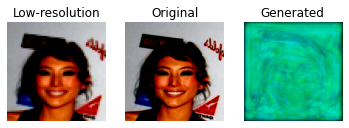

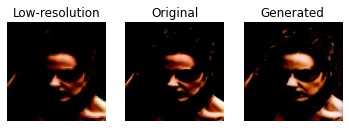

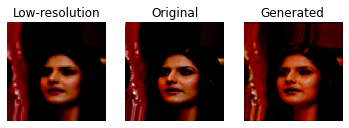

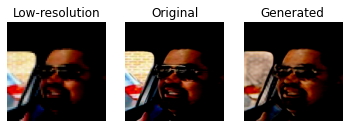

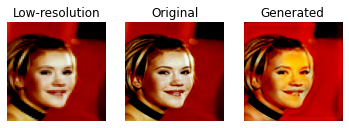

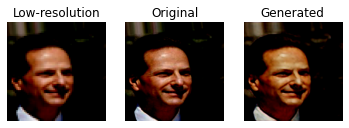

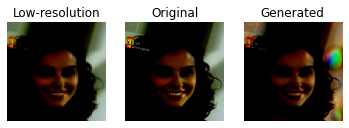

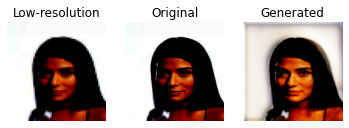

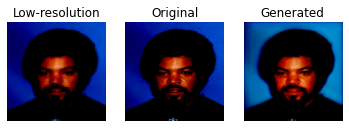

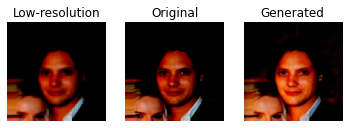

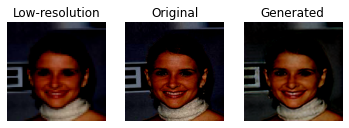

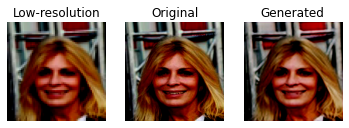

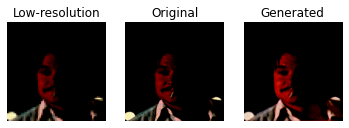

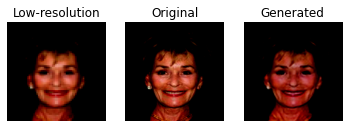

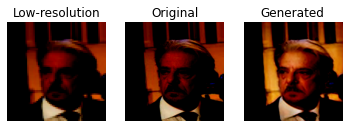

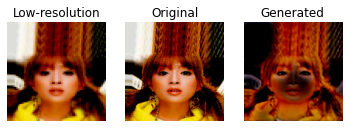

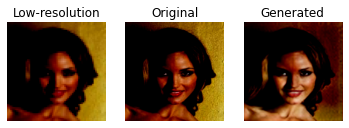

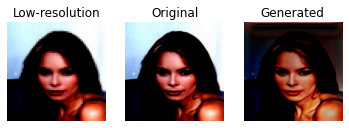

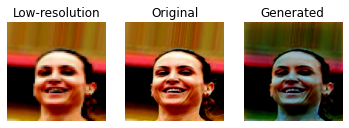

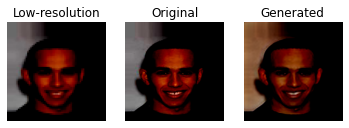

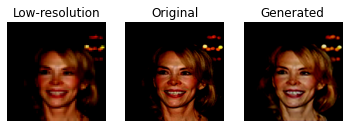

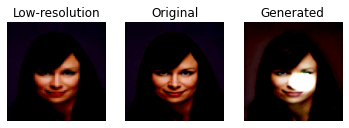

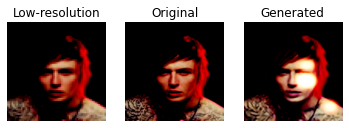

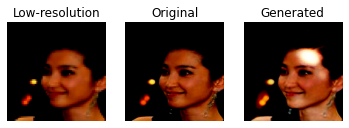

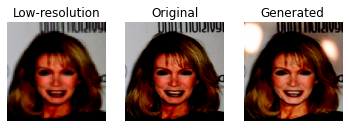

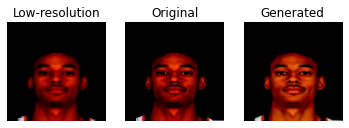

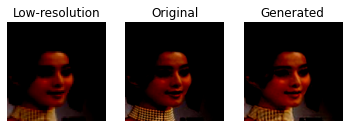

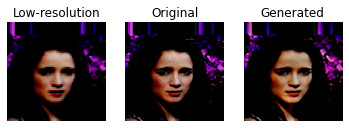

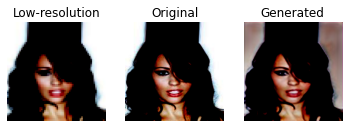

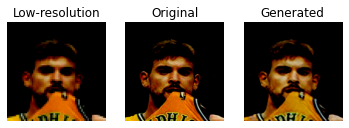

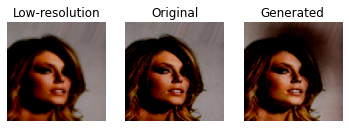

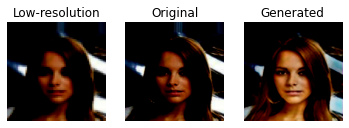

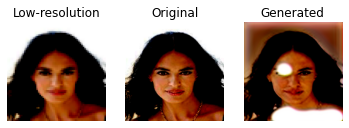

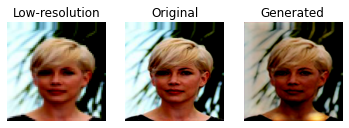

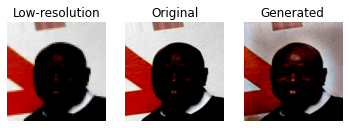

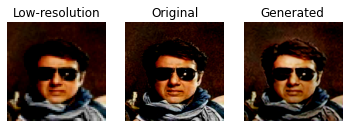

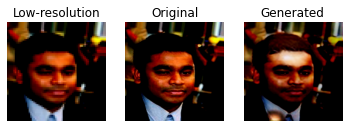

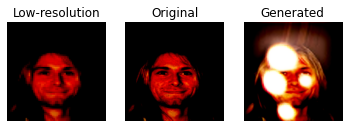

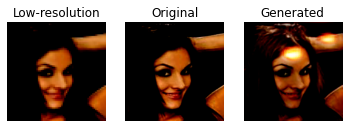

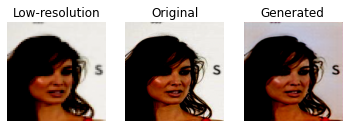

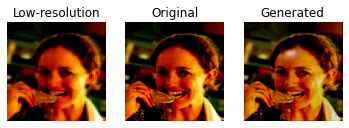

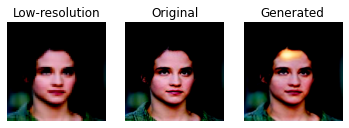

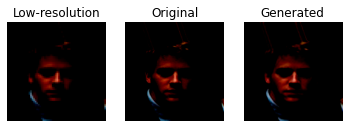

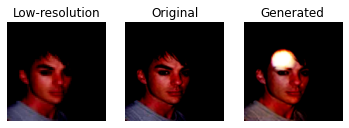

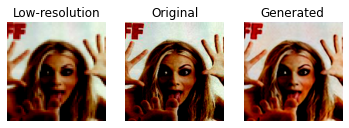

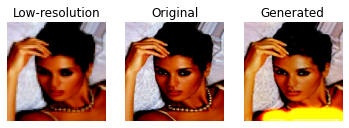

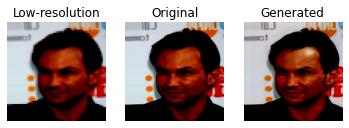

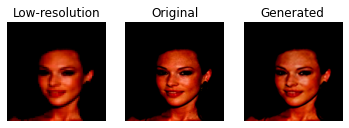

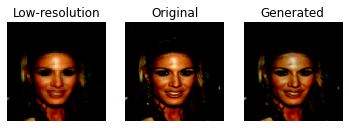

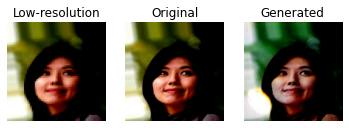

In [ ]:
#for epoch in range(epochs):
    print("Epoch:{}".format(epoch))
 
    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)

    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    high_resolution_images.shape

    generated_high_resolution_images = generator.predict(low_resolution_images)
    print(batch_size)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    print("d_loss:", d_loss)


    high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)

    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.


    image_features = vgg.predict(high_resolution_images)


    g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                              [real_labels, image_features])

    print("g_loss:", g_loss)


    write_log(tensorboard, 'g_loss', g_loss[0], epoch)
    write_log(tensorboard, 'd_loss', d_loss[0], epoch)

    if epoch % 200 == 0:
        high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=batch_size,
                                                                      low_resolution_shape=low_resolution_shape,
                                                                      high_resolution_shape=high_resolution_shape)
      
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        generated_images = generator.predict_on_batch(low_resolution_images)

        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img,
                        path="/content/drive/My Drive/Datasets/results/img_{}_{}".format(epoch, index))


11. Save the models

In [ ]:
# Save models
#generator.save_weights("/content/drive/My Drive/Datasets/generator10k.h5")
#discriminator.save_weights("/content/drive/My Drive/Datasets/discriminator10k.h5")

In [ ]:
def save_images_gen(low_resolution_image, generated_image, path):
    """
    Save images in a single figure
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("Low-resolution")

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("Generated")

    plt.savefig(path)

## Test the model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

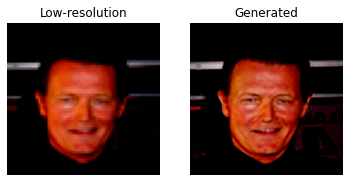

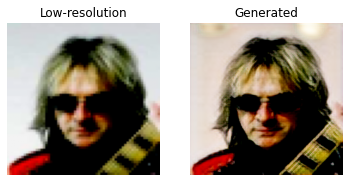

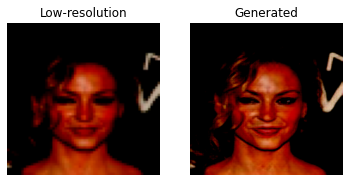

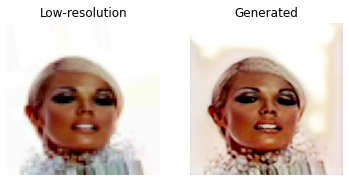

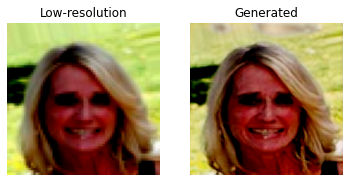

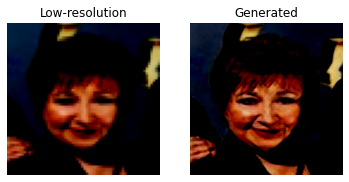

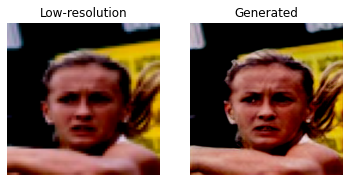

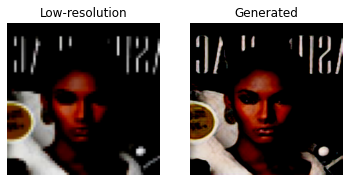

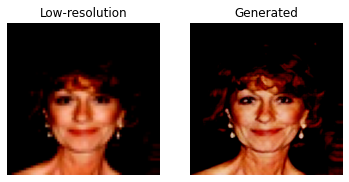

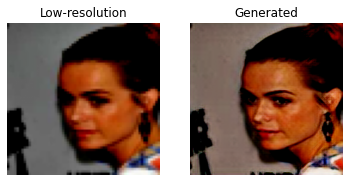

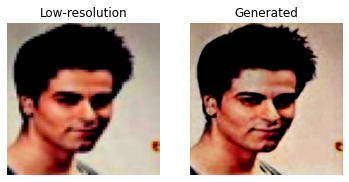

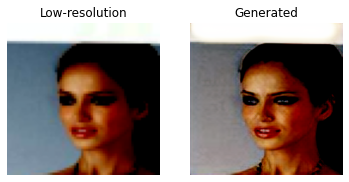

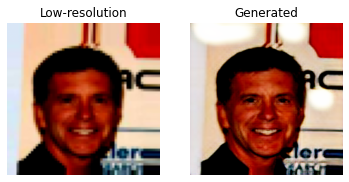

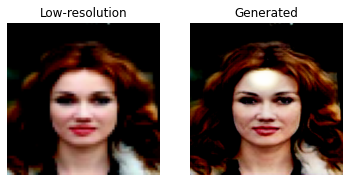

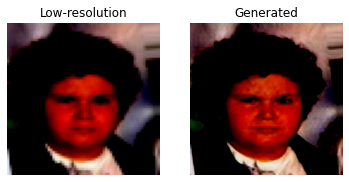

In [ ]:

generator = build_generator()

generator.load_weights("/content/drive/My Drive/Datasets/generator10k.h5")

high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=15,
                                                              low_resolution_shape=low_resolution_shape,
                                                              high_resolution_shape=high_resolution_shape)

high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

generated_images = generator.predict_on_batch(low_resolution_images)

for index, img in enumerate(generated_images):
    save_images_gen(low_resolution_images[index], img,
                path="/content/drive/My Drive/Datasets/generated10k/gen_{}".format(index))

In [ ]:
generator = build_generator()

generator.load_weights("/content/drive/My Drive/Datasets/generator10k.h5")

high_resolution_images, low_resolution_images = sample_images(data_dir=data_dir, batch_size=10,
                                                              low_resolution_shape=low_resolution_shape,
                                                              high_resolution_shape=high_resolution_shape)

high_resolution_images = high_resolution_images / 127.5 - 1.
low_resolution_images = low_resolution_images / 127.5 - 1.

generated_images = generator.predict_on_batch(low_resolution_images)

for index, img in enumerate(generated_images):
    save_images(low_resolution_images[index], high_resolution_images[index], img,
                path="/content/drive/My Drive/Datasets/generated/gen_{}".format(index))